# Important Frequencies Selection

## Import Libraries and seed
Import the necessary libraries for data processing, model building, training, and evaluation. Adding a seed ensures reproducibility by making sure that the random number generation is consistent across different runs.

In [2]:
import os
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import joblib
import matplotlib.pyplot as plt
import graphviz 
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier

from scipy.stats import zscore

# import wandb

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    return seed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Set seed for reproducibility
seed = set_seed(42)


Using device: cpu


In [3]:
def load_data_from_directory(input_path):
    data_frames = []
    for file in os.listdir(input_path):
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(input_path, file), delimiter=';', header=0)
            data_frames.append(df)
    data = pd.concat(data_frames, ignore_index=True)

    return data

## Preprocessing Data
Define a function to preprocess the data. This includes encoding categorical labels and standardizing the features.

In [4]:
def calculate_averages_and_dispersion(df, data_percentage):

    results = []
    for (sample, freq), group in df.groupby(['Sample', 'Frequency (GHz)']):
        window_size = max(1, int(len(group) * data_percentage / 100))
        # print(f"Processing sample: {sample}, frequency: {freq} with window size: {window_size}")
        for start in range(0, len(group), window_size):
            window_data = group.iloc[start:start + window_size]
            mean_values = window_data[['LG (mV)', 'HG (mV)']].mean()
            std_deviation_values = window_data[['LG (mV)', 'HG (mV)']].std()
            results.append({
                'Frequency (GHz)': freq,
                'LG (mV) mean': mean_values['LG (mV)'],
                'HG (mV) mean': mean_values['HG (mV)'],
                'LG (mV) std deviation': std_deviation_values['LG (mV)'],
                'HG (mV) std deviation': std_deviation_values['HG (mV)'],
                # 'Thickness (mm)': window_data['Thickness (mm)'].iloc[0], ## COMMENT
                'Sample': sample,
            })
    results_df = pd.DataFrame(results)
    # results_df.to_csv(output_file, sep=';', index=False)
    # print(f"Processed {input_file} and saved to {output_file}")
    # print(results_df)
    return results_df

## Pivoting Frequency values to columns

In [5]:
def freq_as_variable(df, data_percentage):
    '''Modify df to have Frequency values (100,110,120 and so on) as input variables in the columns'''

    # Remove Thickness column
    if 'Thickness (mm)' in df.columns:
        df = df.drop(columns=['Thickness (mm)'])

    if data_percentage > 0:
        # 1s window_size 100/27s = 3.7% of the data is used for each window
        df_window = calculate_averages_and_dispersion(df, data_percentage) 

        # Add a unique identifier column to avoid duplicate entries in the index
        df_window['unique_id'] = df_window.groupby(['Sample', 'Frequency (GHz)']).cumcount()

        # Pivot the DataFrame to wide format
        df_pivot = df_window.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')

        # Flatten the MultiIndex columns - Ordered by Frequency + (HG mean, HG std deviation, LG mean, LG std deviation)
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]

        # Drop columns with all NaN values
        df_pivot = df_pivot.dropna(axis=1, how='all')

        # Reset index to make 'Sample' and 'unique_id' columns again
        df_pivot = df_pivot.reset_index()

        # Remove 'unique_id' column
        df_pivot = df_pivot.drop(columns=['unique_id'])
    else:
        # If data_percentage is 0, do not calculate mean and std deviation, use the original data
        df['unique_id'] = df.groupby(['Sample', 'Frequency (GHz)']).cumcount()
        df_pivot = df.pivot(index=['Sample', 'unique_id'], columns='Frequency (GHz)')
        df_pivot.columns = [' '.join([str(col[1]), str(col[0])]) for col in df_pivot.columns]
        df_pivot = df_pivot.dropna(axis=1, how='all')
        df_pivot = df_pivot.reset_index()
        df_pivot = df_pivot.drop(columns=['unique_id'])

    # Optional - Sort the columns if needed
    df_pivot = df_pivot.reindex(sorted(df_pivot.columns), axis=1)

    return df_pivot

In [6]:
# Load the data from the directory
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test'
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/'

df = load_data_from_directory(input_path)

df = pd.concat([df[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df[['Sample']]], axis=1)

df_ori = df.copy()

# Find if value samples have '_' in the name and remove everything after '_' 
# df['Sample'] = df['Sample'].str.split('_').str[0]
df['Sample'] = df['Sample'].str[0]

df.head(10)


,Frequency (GHz),LG (mV),HG (mV),Sample
0,100.0,0.671469,20.815529,B
1,100.0,-0.305213,22.463679,B
2,100.0,-0.122085,17.458186,B
3,100.0,0.122085,20.662922,B
4,100.0,-0.061043,22.646807,B
5,100.0,0.396777,17.946526,B
6,100.0,-0.732511,23.989744,B
7,100.0,0.671469,20.815529,B
8,100.0,0.183128,17.641313,B
9,100.0,-0.122085,15.901599,B


## Balance Dataset

C:\Users\Danim\AppData\Local\Temp\ipykernel_49348\3669193858.py:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


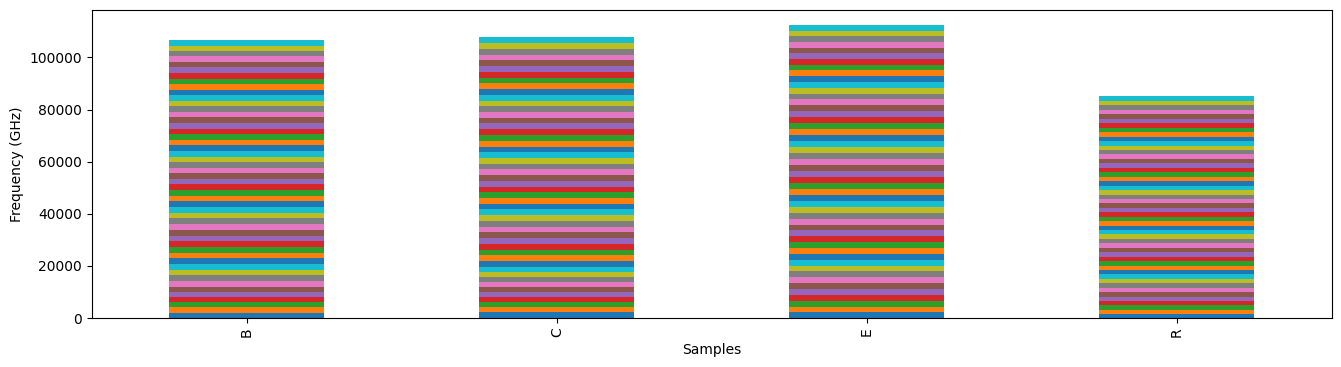

Mean value: 2061


C:\Users\Danim\AppData\Local\Temp\ipykernel_49348\3669193858.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


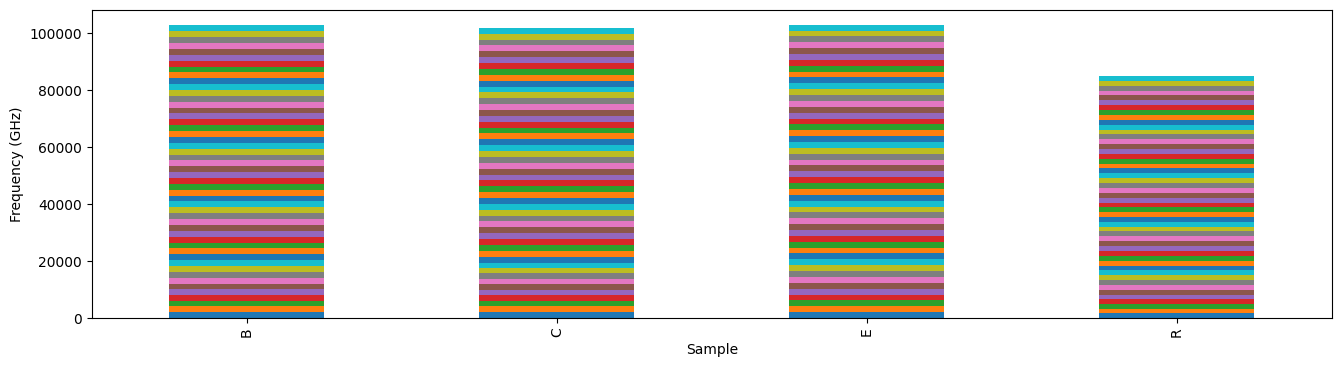

In [7]:
# Number of samples per frequency and Sample
bx = df.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_xlabel('Samples')
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
#no legend
bx.get_legend().remove()
plt.show()

# Balance the data by taking the mode of samples per frequency
mean= int(df.groupby(['Sample', 'Frequency (GHz)']).size().mean())
print(f'Mean value: {mean}')


# Function to reduce samples to the mean value
def reduce_to_mean(df, sample, frequency, mean):
    # Filter the DataFrame for the specific sample and frequency
    freq_df = df[(df['Sample'] == sample) & (df['Frequency (GHz)'] == frequency)]
    # If the number of samples is greater than the mean, sample down to the mean
    if len(freq_df) > mean:
        return freq_df.sample(n=mean, random_state=42)
    return freq_df

# Apply the function to reduce samples for each combination of Sample and Frequency (GHz)
balanced_data = []
for (sample, frequency), group in df.groupby(['Sample', 'Frequency (GHz)']):
    balanced_data.append(reduce_to_mean(df, sample, frequency, mean))

# Combine the balanced samples into a single DataFrame
df_balanced = pd.concat(balanced_data)

bx = df_balanced.groupby(['Sample', 'Frequency (GHz)']).size().unstack().plot.bar(figsize=(16, 4), stacked=True)
bx.set_ylabel('Frequency (GHz)')
plt.tight_layout()
# legend small
bx.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#remove legend
bx.get_legend().remove()
plt.show()

## Data Feature Transformation Visualization

In [ ]:
# Group by 'Sample' and 'Frequency (GHz)' and calculate the mean and standard deviation
mean_std_df = df_ori.groupby(['Sample', 'Frequency (GHz)']).agg(
    LG_mean=('LG (mV)', 'mean'),
    LG_std=('LG (mV)', 'std'),
    HG_mean=('HG (mV)', 'mean'),
    HG_std=('HG (mV)', 'std')
).reset_index()

print(mean_std_df)

# Substract the HG mean value of the previous frequency 
# Create a new DataFrame to store the differences
diff_df = mean_std_df.copy()

# Calculate the difference in HG and LGmean values between consecutive frequencies for each sample
diff_df['HG_mean_diff'] = diff_df.groupby('Sample')['HG_mean'].diff()
diff_df['LG_mean_diff'] = diff_df.groupby('Sample')['LG_mean'].diff()

# Rows where the difference could not be calculated are equal to 0
diff_df['HG_mean_diff'] = diff_df['HG_mean_diff'].fillna(0)
diff_df['LG_mean_diff'] = diff_df['LG_mean_diff'].fillna(0)

print(diff_df)


# Plot the difference in HG mean values for each sample
unique_samples = diff_df['Sample'].unique()

fig, axes = plt.subplots((len(unique_samples) + 3) // 4, 4, figsize=(20, 5 * ((len(unique_samples) + 3) // 4)), sharex=True)

for i, sample in enumerate(unique_samples):
    row, col = divmod(i, 4)
    sample_df = diff_df[diff_df['Sample'] == sample]
    sample_df.plot(x='Frequency (GHz)', y='HG_mean_diff', ax=axes[row, col], label=sample)
    axes[row, col].set_ylabel('HG Mean Difference')
    axes[row, col].legend(title='Sample')
    axes[row, col].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure integer ticks
    axes[row, col].xaxis.set_major_locator(plt.MultipleLocator(5))  # Add more ticks
    axes[row, col].grid(True, alpha=0.5)  # Add grid with transparency

for j in range(i + 1, len(axes.flatten())):
    fig.delaxes(axes.flatten()[j])

axes[-1, 0].set_xlabel('Frequency (GHz)')
plt.tight_layout()
plt.show()


# Plot the difference in HG mean values for each group of samples starting with the same letter
unique_sample_groups = sorted(set(sample[0] for sample in unique_samples))

# Calculate the number of rows needed
n_rows = len(unique_sample_groups)

fig, axes = plt.subplots(n_rows, 1, figsize=(20, 5 * n_rows), sharex=True)

# Ensure axes is always a 1D array
if n_rows == 1:
    axes = np.array([axes])

for i, group in enumerate(unique_sample_groups):
    group_samples = [sample for sample in unique_samples if sample.startswith(group)]
    for sample in group_samples:
        sample_df = diff_df[diff_df['Sample'] == sample]
        sample_df.plot(x='Frequency (GHz)', y='HG_mean_diff', ax=axes[i], label=sample)
    axes[i].set_ylabel('HG Mean Difference')
    axes[i].legend(title='Sample')
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Ensure integer ticks
    axes[i].xaxis.set_major_locator(plt.MultipleLocator(5))  # Add more ticks
    axes[i].grid(True, alpha=0.5)  # Add grid with transparency

axes[-1].set_xlabel('Frequency (GHz)')
plt.tight_layout()
plt.show()


## Sample a test set

In [9]:
df_train = df_balanced.copy()

test_percentage = 0.2

# # Shuffle the data
# df_train = df_train.sample(frac=1, random_state=42)

train_set, test_set = train_test_split(df_train, test_size=test_percentage, random_state=42) 

# stratify=df['Sample'] to keep the same proportion of samples in the train and test set

train_set.head()




,Frequency (GHz),LG (mV),HG (mV),Sample
376084,470.0,0.061043,83.262116,R
297639,570.0,0.335734,31.681113,E
29193,130.0,48.803564,-0.244164,B
412350,590.0,-0.671469,29.697228,R
97925,440.0,0.030521,103.009401,B


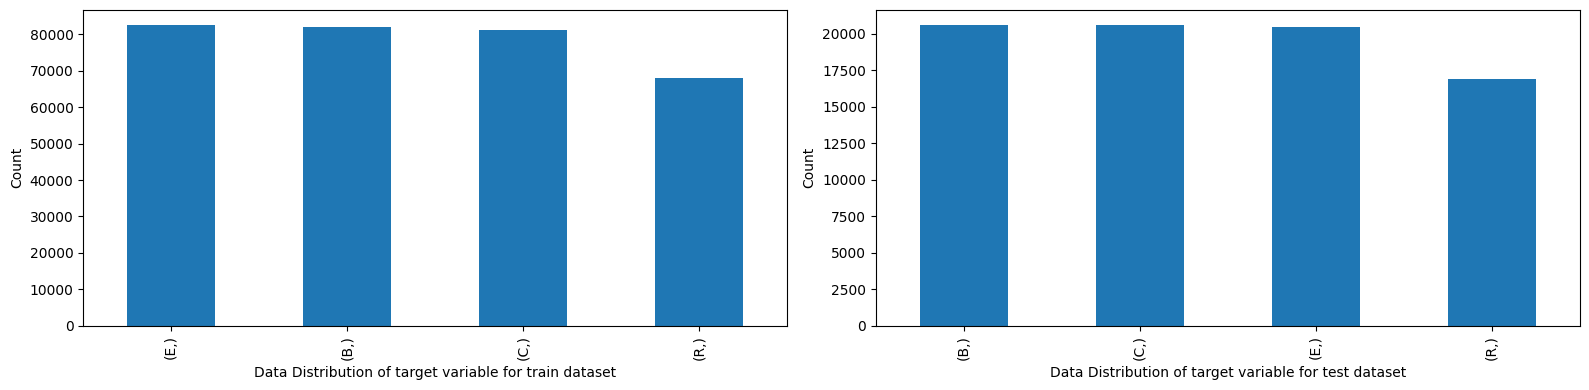

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Plot train set
train_set[['Sample']].value_counts().plot.bar(ax=ax[0], legend=False)
ax[0].set_xlabel('Data Distribution of target variable for train dataset')
ax[0].set_ylabel('Count')

# Plot test set
test_set[['Sample']].value_counts().plot.bar(ax=ax[1], legend=False)
ax[1].set_xlabel('Data Distribution of target variable for test dataset')
ax[1].set_ylabel('Count')

plt.tight_layout() 
plt.show()

In [12]:
train_ex = train_set.copy()

# train_ex.info()
# train_ex.describe()

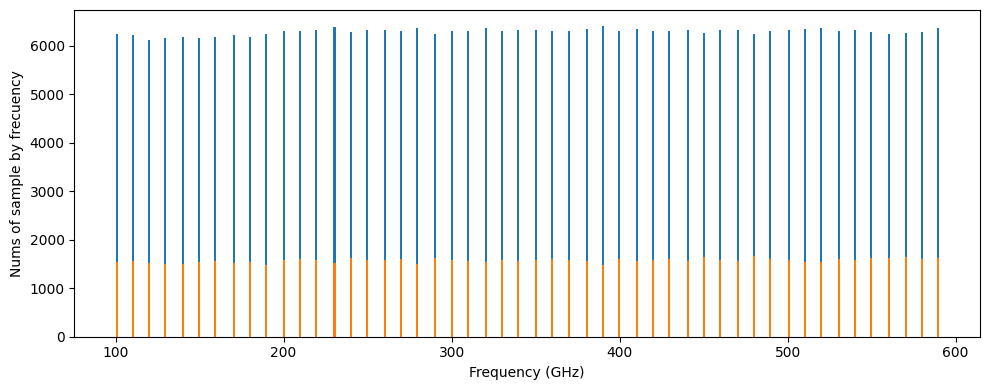

In [13]:
ax = train_ex['Frequency (GHz)'].plot.hist(figsize=(10, 4), bins=408)
ax = test_set['Frequency (GHz)'].plot.hist(ax=ax, bins=408)
ax.set_xlabel('Frequency (GHz)')
ax.set_ylabel('Nums of sample by frecuency')
plt.tight_layout()
plt.show()

In [14]:
# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 48
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

# data_percentage = 100
# data_percentage_test = 100

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Load just a % of the data
# df_sample = train_set.sample(frac=0.02, random_state=42)


# Introduce Frequency values as input variables
train_set_test = freq_as_variable(train_set, data_percentage)
test_set_test = freq_as_variable(test_set, data_percentage_test)


# If a row has any NaN value, remove that row
train_set_test = train_set_test.dropna()
test_set_test = test_set_test.dropna()

## Save the processed data to a CSV file

# output_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'
# output_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/train_set.csv'
# output_path_test = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_1_plastics/processed_27s/training_file/test_set.csv'

# train_set_test.to_csv(output_path, sep = ';', index=False)
# test_set_test.to_csv(output_path_test, sep = ';', index=False)




Data percentage: 0.26041666666666663%
Data percentage test: 1.0416666666666665%


# Prepare Training Data
## Split the data into X and y


In [15]:
def preprocess_data(df, labels, freqs, drop_sample=True, eliminate_std_dev=False):
    # Reduce number of different samples for testing
    X_ = df[df['Sample'].isin(labels)]

    y_ = X_['Sample']

    if drop_sample:
        X_ = X_.drop(columns=['Sample'])
        
    if freqs:
        # Subset of specific frequencies to use as input features (or without mean)
        columns = [f'{freq}.0 HG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) mean' for freq in freqs] + \
                  [f'{freq}.0 HG (mV)' for freq in freqs] + \
                  [f'{freq}.0 LG (mV)' for freq in freqs] + \
                  [f'{freq}.0 HG (mV) std deviation' for freq in freqs] + \
                  [f'{freq}.0 LG (mV) std deviation' for freq in freqs] + \
                  ['Sample']


        # Filter columns that exist in X_
        existing_columns = [col for col in columns if col in X_.columns]

        # Check if existing_columns is empty
        if not existing_columns:
            print("No matching columns found in X_.")
        else:
            X_ = X_[existing_columns]

        # Sort columns by frequency value
        X_ = X_.reindex(sorted(X_.columns), axis=1)

    if eliminate_std_dev:
        # Eliminate std dev columns from the input features
        X_ = X_.drop(columns=[col for col in X_.columns if 'std deviation' in col])

    return X_, y_


In [16]:
# Subset of specific Samples to use in the training
# labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
# labels = ['B1', 'C1', 'E3', 'REF']
labels = ['B', 'C', 'E', 'R']


# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360]
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360,340,350,370,380,390,400,410,430,440]
freqs = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
freqs = [310]

# Count number of frequencies
print(f'freqs number: {len(freqs)}')

# freqs = []

# # Shuffle the data
# train_set_test = train_set_test.sample(frac=1, random_state=42)
# test_set_test = test_set_test.sample(frac=1, random_state=42)


X_train, y_train = preprocess_data(train_set_test, labels, freqs, drop_sample=False, eliminate_std_dev=False) 
X_test, y_test = preprocess_data(test_set_test, labels, freqs, drop_sample=False, eliminate_std_dev=False)

# Encode the target variable if it's categorical
if y_train.dtype == 'object':
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)

if y_test.dtype == 'object':
    y_test = le.transform(y_test)


# le is the fitted LabelEncoder - Saving Encoder
joblib.dump(le, 'label_encoder.pkl')


# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)




# Remove sample columns
X_train = X_train.drop(columns=['Sample'])
X_test = X_test.drop(columns=['Sample'])

print(X_train)



freqs number: 1
      310.0 HG (mV) mean  310.0 HG (mV) std deviation  310.0 LG (mV) mean  \
0               0.358628                     0.362311            1.899951   
1               0.373893                     0.292080            2.403553   
2              -0.076312                     0.457138            2.548529   
3               0.106822                     0.235758            2.624832   
4              -0.160244                     0.169691            2.296728   
...                  ...                          ...                 ...   
1782            0.213635                     0.030518            2.309445   
1783            0.386598                     0.216530            2.553616   
1784            0.061043                     0.291142            2.065275   
1785            0.071214                     0.474145            3.225084   
1786           -0.030504                     0.455784            2.706222   

      310.0 LG (mV) std deviation  
0                      

In [ ]:
## Data transformation 
# 1) Inputs: xt - (xt-1) --First-order differences
# 2) Inputs: (xt/(xt-1)) - 1 --Escalado relativo

In [ ]:
#### TBD ####
# FEATURE TRANSFORMATIONS
# feature engineering transformation with autofeat
# from autofeat import AutoFeatClassifier
# from autofeat import AutoFeatRegressor

### Principal Component Analysis

In [ ]:
# Apply PCA
n_components = 5
pca = PCA(n_components)  # Reduce to 2 components for visualization
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
y_pca = y_train

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.step(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='cumulative explained variance', color='orange')
plt.fill_between(range(1, n_components+1), np.cumsum(pca.explained_variance_ratio_), step='mid', alpha=0.2, color='orange')
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_, alpha=1.0, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


### VISUALIZATION ###
# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pca, cmap = 'tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 10
for i, label in enumerate(labels):
    plt.text(X_train_pca[y_pca == i, 0].mean() , X_train_pca[y_pca == i, 1].mean() + offset, label,
             ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))


plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('PCA of Training Data')


plt.show()


# Show how the principal components are related to the original features
# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_train.columns)
# Transpose the DataFrame
components = components.T
# Display the highest and lowest n variables of the first 3 components
n= 10
for i in range(n_components):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')


## NON PCA VISUALIZATION ##
# Choose specific variables for visualization
var1 = '410.0 HG (mV)'
var2 = '360.0 HG (mV)'
# var2 = '320.0 HG (mV) std deviation'

try:
    X_train[var1].describe()
except Exception as e:
    var1 = f'{var1} mean'
    var2 = f'{var2} mean'

# Plot the chosen input variables for visualization
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_train[var1], X_train[var2], c=y_train, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0
unique_labels = np.unique(y_train)
for i, label in enumerate(unique_labels):
    plt.text(X_train[y_train == label][var1].mean(), X_train[y_train == label][var2].mean() + offset, 
             labels[label], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()



In [ ]:
# Model Parameters
input_size = X_train.shape[1]
output_size = len(np.unique(y_train))
seed = set_seed(42)

input_size, output_size

X_train.head(10)


### Define Models
- Random Forest
- Naive-Bayes
- Logistic Regression
- Gradient Boosting

In [18]:
def random_forest_model(X_train, y_train, seed):
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    return rf_model

def naive_bayes_model(X_train, y_train):
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)
    return nb_model

def logistic_regression_model(X_train, y_train, seed):
    lr_model = LogisticRegression(max_iter=10000, random_state=seed)
    lr_model.fit(X_train, y_train)
    return lr_model

def gradient_boosting_model(X_train, y_train, seed):
    gb_model = GradientBoostingClassifier(n_estimators=10, random_state=seed)
    gb_model.fit(X_train, y_train)
    return gb_model

### Train all Models

In [19]:
def train_models(X_train, y_train, seed):
    rf_model = random_forest_model(X_train, y_train, seed)
    nb_model = naive_bayes_model(X_train, y_train)
    lr_model = logistic_regression_model(X_train, y_train, seed)
    gb_model = gradient_boosting_model(X_train, y_train, seed)
    return rf_model, nb_model, lr_model, gb_model

def save_models(rf_model, nb_model, lr_model, gb_model):
    joblib.dump(rf_model, 'random_forest_model.pkl')
    joblib.dump(nb_model, 'naive_bayes_model.pkl')
    joblib.dump(lr_model, 'logistic_regression_model.pkl')
    joblib.dump(gb_model, 'gradient_boosting_model.pkl')

# Train the models
rf_model, nb_model, lr_model, gb_model = train_models(X_train, y_train, seed)

In [ ]:
# Function to apply confidence threshold
def apply_confidence_threshold(probabilities, threshold=0.5):
    max_probs = np.max(probabilities, axis=1)
    predictions = np.argmax(probabilities, axis=1)
    # Replace predictions with -1 (unknown) where confidence is below threshold
    predictions[max_probs < threshold] = -1
    return predictions, max_probs


In [124]:
def save_model_results(models, data, accuracies, precisions, recalls, f1_scores, predictions, n_features, freqs, 
                      csv_path='comparison_results.csv'):
    
    # Determine test number
    if os.path.exists(csv_path):
        existing_results = pd.read_csv(csv_path, sep=';')
        current_test = existing_results['Test'].max() + 1
    else:
        current_test = 1

    # Create results DataFrame
    results_df = pd.DataFrame({
        'Test': [current_test] * len(models),
        'Data': [data] * len(models),
        'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1-Score': f1_scores,
        'Predictions': predictions,
        'Algorithm': models,
        'Num_Features': [n_features] * len(models),
        'Num Frequencies': [len(freqs)] * len(models),
        'Frequencies': [', '.join([f"{freq:.0f}" for freq in freqs])] * len(models)
    })

    # Format float columns
    float_columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    results_df[float_columns] = results_df[float_columns].round(4)

    # Append or create results file
    if os.path.exists(csv_path):
        updated_results = pd.concat([existing_results, results_df], ignore_index=True)
    else:
        updated_results = results_df

    # Save updated results
    updated_results.to_csv(csv_path, index=False, sep=';')

    print(f"\nTest #{current_test} Results:")
    print(results_df)
    # print("\nAll Results:")
    # print(updated_results)
    
    return updated_results

In [73]:
def evaluate_models(y_test, y_pred, report=True):
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    predictions_list = []

    for i, y_pred_i in enumerate(y_pred):
        accuracy = accuracy_score(y_test, y_pred_i)
        precision = precision_score(y_test, y_pred_i, average='weighted')
        recall = recall_score(y_test, y_pred_i, average='weighted')
        f1 = f1_score(y_test, y_pred_i, average='weighted')

        print(f"Model {i+1} - Accuracy: {accuracy}")
        print(f"Model {i+1} - Precision: {precision}")
        print(f"Model {i+1} - Recall: {recall}")
        print(f"Model {i+1} - F1: {f1}")

        if report:
            # Classification report
            print(f"Model {i+1} - Classification Report:\n", classification_report(y_test, y_pred_i), '\n')

        # Predictions made per class with its label encoded value
        predictions = dict(sorted(Counter(y_pred_i).items()))
        print(f"Model {i+1} - Predictions: {predictions}\n")

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        predictions_list.append(predictions)

    return accuracies, precisions, recalls, f1_scores, predictions_list

In [ ]:
def get_feature_importances(rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30):
    feature_names = X_train.columns

    # Random Forest feature importances
    rf_feature_importances = rf_model.feature_importances_
    rf_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_feature_importances})
    rf_feature_importances_df = rf_feature_importances_df.sort_values('Importance', ascending=False)

    # Logistic Regression feature importances
    lr_feature_importances = lr_model.coef_[0]
    lr_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_feature_importances})
    lr_feature_importances_df = lr_feature_importances_df.sort_values('Importance', ascending=False)

    # Gradient Boosting feature importances
    gb_feature_importances = gb_model.feature_importances_
    gb_feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': gb_feature_importances})
    gb_feature_importances_df = gb_feature_importances_df.sort_values('Importance', ascending=False)

    # Naive Bayes permutation importance
    result = permutation_importance(nb_model, X_train, y_train, n_repeats=5, random_state=seed, n_jobs=1)
    sorted_idx = result.importances_mean.argsort()[::-1]
    nb_feature_importances_df = pd.DataFrame({'Feature': feature_names[sorted_idx], 'Importance': result.importances_mean[sorted_idx]})

    if plot:
        # Font size
        plt.rcParams.update({'font.size': 6})

        # Plot the feature importances
        plt.figure(figsize=(20, 10))
        plt.barh(rf_feature_importances_df['Feature'][:n], rf_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Random Forest Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(lr_feature_importances_df['Feature'][:n], lr_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Logistic Regression Feature Importances')
        plt.show()

        plt.figure(figsize=(20, 10))
        plt.barh(gb_feature_importances_df['Feature'][:n], gb_feature_importances_df['Importance'][:n])
        plt.xlabel('Importance')
        plt.title('Gradient Boosting Feature Importances')
        plt.show()

        plt.figure(figsize=(12, 8))
        plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_train.columns[sorted_idx])
        plt.xlabel('Permutation Importance')
        plt.title('Naive Bayes Permutation Feature Importance')
        plt.show()

    return rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df


In [83]:
# Make Predictions

y_pred = []
y_pred.append(rf_model.predict(X_test))
y_pred.append(nb_model.predict(X_test))
y_pred.append(lr_model.predict(X_test))
y_pred.append(gb_model.predict(X_test))

# Call the function
accuracies, precisions, recalls, f1_scores, predictions = evaluate_models(y_test, y_pred, report=False)

# Define model names
models = ['RF', 'NB', 'LR', 'GB']

# # Get feature importance values
# rf_feature_importances_df, lr_feature_importances_df, gb_feature_importances_df, nb_feature_importances_df = get_feature_importances(
#     rf_model, lr_model, gb_model, nb_model, X_train, y_train, seed, plot=False, n=30)

##TBD 
# - ADD FEATURE IMPORTANCE TO CSV - HOW?

updated_results = save_model_results(
    models=models,
    accuracies=accuracies,
    precisions=precisions,
    recalls=recalls,
    f1_scores=f1_scores,
    predictions=predictions,
    n_features=X_train.shape[1],
    freqs=freqs
)


Model 1 - Accuracy: 0.6259541984732825
Model 1 - Precision: 0.6206698928161737
Model 1 - Recall: 0.6259541984732825
Model 1 - F1: 0.6225695201694862
Model 1 - Predictions: {0: 99, 1: 97, 2: 86, 3: 111}

Model 2 - Accuracy: 0.6259541984732825
Model 2 - Precision: 0.617847132080441
Model 2 - Recall: 0.6259541984732825
Model 2 - F1: 0.6197743041487893
Model 2 - Predictions: {0: 78, 1: 94, 2: 105, 3: 116}

Model 3 - Accuracy: 0.6183206106870229
Model 3 - Precision: 0.6026820628783551
Model 3 - Recall: 0.6183206106870229
Model 3 - F1: 0.6059361165036163
Model 3 - Predictions: {0: 66, 1: 98, 2: 110, 3: 119}

Model 4 - Accuracy: 0.6081424936386769
Model 4 - Precision: 0.6095846182771489
Model 4 - Recall: 0.6081424936386769
Model 4 - F1: 0.6076433159997221
Model 4 - Predictions: {0: 84, 1: 94, 2: 113, 3: 102}


Test #4 Results:
   Test Algorithm  Accuracy  Precision  Recall  F1-Score  \
0     4        RF    0.6260     0.6207  0.6260    0.6226   
1     4        NB    0.6260     0.6178  0.6260  

## Threshold for Unknown class

In [133]:
# Get predictions and probabilities
rf_probs = rf_model.predict_proba(X_test)
nb_probs = nb_model.predict_proba(X_test)
lr_probs = lr_model.predict_proba(X_test)
gb_probs = gb_model.predict_proba(X_test)

# Apply thresholding
thresholds = [0.5, 0.7, 0.9]
models = ['RF', 'NB', 'LR', 'GB']
prob_list = [rf_probs, nb_probs, lr_probs, gb_probs]

for threshold in thresholds:
    print(f"\nResults with confidence threshold = {threshold}")
    print("-" * 50)
    
    for model_name, probs in zip(models, prob_list):
        predictions, confidences = apply_confidence_threshold(probs, threshold)
        
        # Convert -1 to 'unknown' for metrics
        valid_mask = predictions != -1
        
        if np.any(valid_mask):
            # Calculate metrics only on predictions above threshold
            accuracy = accuracy_score(y_test[valid_mask], predictions[valid_mask])
            precision = precision_score(y_test[valid_mask], predictions[valid_mask], 
                                     average='weighted')
            recall = recall_score(y_test[valid_mask], predictions[valid_mask], 
                                average='weighted')
            
            print(f"\n{model_name}:")
            print(f"Samples retained: {sum(valid_mask)}/{len(predictions)} "
                  f"({100*sum(valid_mask)/len(predictions):.1f}%)")
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            
            # Plot confidence distribution
            plt.figure(figsize=(8, 4))
            plt.hist(confidences, bins=50)
            plt.axvline(x=threshold, color='r', linestyle='--', 
                       label=f'Threshold ({threshold})')
            plt.title(f'Confidence Distribution - {model_name}')
            plt.xlabel('Confidence Score')
            plt.ylabel('Count')
            plt.legend()
            plt.show()

print(rf_probs)


Results with confidence threshold = 0.5
--------------------------------------------------


ValueError: Mix of label input types (string and number)

In [ ]:
## Export Random Forest model with graphviz
def export_random_forest_model(rf_model, feature_names, output_file='random_forest_model'):
    # Export the first tree in the Random Forest
    dot_data = export_graphviz(
        rf_model.estimators_[0], 
        out_file=None, 
        filled=True, 
        rounded=True, 
        special_characters=True,
        feature_names=feature_names
    )

    # Create a graph from the dot data
    graph = graphviz.Source(dot_data)

    # Render the graph to a file
    graph.render(output_file)

feature_names = X_train.columns.tolist()  # Replace with actual feature names
# Call the function
export_random_forest_model(rf_model, feature_names)


'random_forest_model.pdf'

## Confusion Matrix

In [86]:
## Confusion matrix with matplotlib
def plot_confusion_matrix(y_true, y_pred, labels):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix[i, j] / np.sum(conf_matrix, axis=1)[i] * 100:.1f}%)',
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=9,
                     ha='center', va='center', color='white')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(np.arange(len(labels)), labels, rotation=45)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
plot_confusion_matrix(y_test, y_pred[0], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[1], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[2], np.unique(y_test))
plot_confusion_matrix(y_test, y_pred[3], np.unique(y_test))

## Define training and testing data

In [ ]:
# Subset of specific Samples to use in the training
labels = ['B', 'C', 'E', 'R']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used

freqs = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]
freqs = [310]

## Load and preprocess Other Test Data (Experiment 4)
Prepare new sample for testing (Testing other samples, out of initial dataset)

In [127]:
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/new_sample/'

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

df_new_sample['Sample'] = df_new_sample['Sample'].str[0]
print(df_new_sample.head(10))

# Calculate the percentage of data used for each window
time_window_s = 0.1
stabilised_time_s = 24
data_percentage = (100/(stabilised_time_s*(1-test_percentage))) * time_window_s
data_percentage_test = (100/(stabilised_time_s*(test_percentage))) * time_window_s

print(f"Data percentage: {data_percentage}%")
print(f"Data percentage test: {data_percentage_test}%")

# Introduce Frequency values as input variables

df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

# If a row has any NaN value, remove that row
df_new_sample = df_new_sample.dropna()



# Add .0 on every Frequency column value to match the format of the training data
# df_new_sample['Frequency (GHz)'] = df_new_sample['Frequency (GHz)'].astype(str) + '.0'
# Encode the target variable if it's categorical
# Encode the target variable if it's categorical
# if y_train.dtype == 'object':
#     le = LabelEncoder()
#     y_train = le.fit_transform(y_train)

# if y_test.dtype == 'object':
#     y_test = le.transform(y_test)

# if df_new_sample.dtype == 'object':
#     df_new_sample = le.transform(df_new_sample)

print(f"New sample shape: {df_new_sample.shape}")
print(f"X_shape: {X_train.shape}")


# load the label encoder
le = joblib.load('label_encoder.pkl')

   Frequency (GHz)   LG (mV)    HG (mV) Sample
0            100.0 -0.640947  25.027469      B
1            100.0  0.244170  23.684531      B
2            100.0 -0.122085  25.027469      B
3            100.0  1.159810  21.639604      B
4            100.0  0.213649  26.248321      B
5            100.0  0.030521  22.219509      B
6            100.0 -0.640947  27.286045      B
7            100.0 -0.122085  27.896471      B
8            100.0 -0.854596  22.280551      B
9            100.0  0.183128  24.294958      B
Data percentage: 0.5208333333333333%
Data percentage test: 2.083333333333333%
New sample shape: (585, 201)
X_shape: (1612, 16)


In [132]:
# Subset of specific Samples to use in the training
labels = ['B', 'C', 'E', 'R']

# Subset of specific frequencies to use as input features, If freqs = [] then all frequencies are used

# Favourite frequencies
freqs = [250,300,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540]

# freqs = [310]

# freqs = []

# # Count number of frequencies
# print(f'freqs number: {len(freqs)}')

# Array with subsets of frequencies to use for training
freqs = [
        [250, 300, 320],
        [330, 340, 350],
        [360, 370, 380],
        [390, 400, 410],
        [420, 430, 440],
        [450, 460, 470],
        [480, 490, 500],
        [510, 520, 530, 540]
    ]
# Add all frequencies one by one
for i in range(100, 591, 10):
    freqs.append([i])

# Add groups of 2 frequencies
for i in range(100, 591, 20):
    freqs.append([i, i+10])

# Add groups of 3 frequencies
for i in range(100, 591, 30):
    freqs.append([i, i+10, i+20])

# Add a group with all frequencies from 100 to 590
freqs.append(list(range(100, 591, 10)))


print(freqs)

for freq in freqs:

    subset_freqs = freq
    print(f'Frequency: {freq}')

    X_train, y_train = preprocess_data(train_set_test, labels, subset_freqs, drop_sample=True, eliminate_std_dev=False) 
    X_test, y_test = preprocess_data(test_set_test, labels, subset_freqs, drop_sample=True, eliminate_std_dev=False)

    print(f"y_train: {y_train}")

    # Define model names
    models = ['RF', 'NB', 'LR', 'GB']

    # Train the models
    rf_model, nb_model, lr_model, gb_model = train_models(X_train, y_train, seed)

    # # Make Predictions
    # y_pred = []
    # y_pred.append(rf_model.predict(X_test))
    # y_pred.append(nb_model.predict(X_test))
    # y_pred.append(lr_model.predict(X_test))
    # y_pred.append(gb_model.predict(X_test))

    # # Evaluate Models
    # accuracies, precisions, recalls, f1_scores, predictions = evaluate_models(y_test, y_pred, report=False)

    # updated_results = save_model_results(
    #     models=models,
    #     data='test',
    #     accuracies=accuracies,
    #     precisions=precisions,
    #     recalls=recalls,
    #     f1_scores=f1_scores,
    #     predictions=predictions,
    #     n_features=X_train.shape[1],
    #     freqs=subset_freqs
    # )


    X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, subset_freqs, drop_sample=True, eliminate_std_dev=False)

    print(f"y_new_sample: {y_new_sample}")

    # Make Predictions
    y_pred_ns = []
    y_pred_ns.append(rf_model.predict(X_new_sample))
    y_pred_ns.append(nb_model.predict(X_new_sample))
    y_pred_ns.append(lr_model.predict(X_new_sample))
    y_pred_ns.append(gb_model.predict(X_new_sample))

    # Evaluate Models
    accuracies, precisions, recalls, f1_scores, predictions = evaluate_models(y_new_sample, y_pred_ns, report=False)
    

    updated_results = save_model_results(
        models=models,
        data='new_sample',
        accuracies=accuracies,
        precisions=precisions,
        recalls=recalls,
        f1_scores=f1_scores,
        predictions=predictions,
        n_features=X_new_sample.shape[1],
        freqs=subset_freqs
    )



[[250, 300, 320], [330, 340, 350], [360, 370, 380], [390, 400, 410], [420, 430, 440], [450, 460, 470], [480, 490, 500], [510, 520, 530, 540], [100], [110], [120], [130], [140], [150], [160], [170], [180], [190], [200], [210], [220], [230], [240], [250], [260], [270], [280], [290], [300], [310], [320], [330], [340], [350], [360], [370], [380], [390], [400], [410], [420], [430], [440], [450], [460], [470], [480], [490], [500], [510], [520], [530], [540], [550], [560], [570], [580], [590], [100, 110], [120, 130], [140, 150], [160, 170], [180, 190], [200, 210], [220, 230], [240, 250], [260, 270], [280, 290], [300, 310], [320, 330], [340, 350], [360, 370], [380, 390], [400, 410], [420, 430], [440, 450], [460, 470], [480, 490], [500, 510], [520, 530], [540, 550], [560, 570], [580, 590], [100, 110, 120], [130, 140, 150], [160, 170, 180], [190, 200, 210], [220, 230, 240], [250, 260, 270], [280, 290, 300], [310, 320, 330], [340, 350, 360], [370, 380, 390], [400, 410, 420], [430, 440, 450], [460

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.0
Model 1 - Precision: 0.0
Model 1 - Recall: 0.0
Model 1 - F1: 0.0
Model 1 - Predictions: {'B': 200, 'C': 229, 'R': 156}

Model 2 - Accuracy: 0.0
Model 2 - Precision: 0.0
Model 2 - Recall: 0.0
Model 2 - F1: 0.0
Model 2 - Predictions: {'C': 192, 'R': 393}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.1744287458573173
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.23100023100023098
Model 3 - Predictions: {'C': 392, 'R': 193}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.17487485518176057
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.2313910943352568
Model 4 - Predictions: {'B': 1, 'C': 391, 'R': 193}


Test #57 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0    57  new_sample    0.0000     0.0000  0.0000    0.0000   
1    57  new_sample    0.00

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3418803418803419
Model 1 - Precision: 0.172666839333506
Model 1 - Recall: 0.3418803418803419
Model 1 - F1: 0.2294498938794241
Model 1 - Predictions: {'C': 396, 'R': 189}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.1744287458573173
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.23100023100023098
Model 2 - Predictions: {'C': 392, 'E': 193}

Model 3 - Accuracy: 0.35384615384615387
Model 3 - Precision: 0.44650282435749566
Model 3 - Recall: 0.35384615384615387
Model 3 - F1: 0.1988637627086943
Model 3 - Predictions: {'C': 578, 'E': 7}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.11688216816421944
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.17420654363329524
Model 4 - Predictions: {'C': 585}


Test #58 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 1.0
Model 1 - Precision: 1.0
Model 1 - Recall: 1.0
Model 1 - F1: 1.0
Model 1 - Predictions: {'B': 193, 'C': 200, 'E': 192}

Model 2 - Accuracy: 1.0
Model 2 - Precision: 1.0
Model 2 - Recall: 1.0
Model 2 - F1: 1.0
Model 2 - Predictions: {'B': 193, 'C': 200, 'E': 192}

Model 3 - Accuracy: 1.0
Model 3 - Precision: 1.0
Model 3 - Recall: 1.0
Model 3 - F1: 1.0
Model 3 - Predictions: {'B': 193, 'C': 200, 'E': 192}

Model 4 - Accuracy: 0.5401709401709401
Model 4 - Precision: 1.0
Model 4 - Recall: 0.5401709401709401
Model 4 - F1: 0.5931928169032241
Model 4 - Predictions: {'B': 2, 'C': 200, 'E': 114, 'R': 269}


Test #59 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0    59  new_sample    1.0000        1.0  1.0000    1.0000   
1    59  new_sample    1.0000        1.0  1.0000    1.0000   
2    59  new

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.5025641025641026
Model 1 - Precision: 0.5471421810184025
Model 1 - Recall: 0.5025641025641026
Model 1 - F1: 0.4835057106912075
Model 1 - Predictions: {'B': 98, 'C': 102, 'E': 307, 'R': 78}

Model 2 - Accuracy: 0.49572649572649574
Model 2 - Precision: 0.49941880341880335
Model 2 - Recall: 0.49572649572649574
Model 2 - F1: 0.4377507088916485
Model 2 - Predictions: {'C': 98, 'E': 400, 'R': 87}

Model 3 - Accuracy: 0.67008547008547
Model 3 - Precision: 0.5471421810184025
Model 3 - Recall: 0.67008547008547
Model 3 - F1: 0.5944470136854907
Model 3 - Predictions: {'C': 200, 'E': 307, 'R': 78}

Model 4 - Accuracy: 0.4735042735042735
Model 4 - Precision: 0.4948303045390424
Model 4 - Recall: 0.4735042735042735
Model 4 - F1: 0.4125888389394837
Model 4 - Predictions: {'B': 5, 'C': 85, 'E': 412, 'R': 83}


Test #60 Results:
 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6666666666666666
Model 1 - Precision: 0.5047107930828861
Model 1 - Recall: 0.6666666666666666
Model 1 - F1: 0.5578320725455362
Model 1 - Predictions: {'C': 198, 'E': 387}

Model 2 - Accuracy: 0.19316239316239317
Model 2 - Precision: 0.41296930689643235
Model 2 - Recall: 0.19316239316239317
Model 2 - F1: 0.12230004986097713
Model 2 - Predictions: {'C': 6, 'E': 494, 'R': 85}

Model 3 - Accuracy: 0.6239316239316239
Model 3 - Precision: 0.6237531459639177
Model 3 - Recall: 0.6239316239316239
Model 3 - F1: 0.6234693363887723
Model 3 - Predictions: {'B': 179, 'C': 200, 'E': 206}

Model 4 - Accuracy: 0.6376068376068376
Model 4 - Precision: 0.4978590166708978
Model 4 - Recall: 0.6376068376068376
Model 4 - F1: 0.5362922131722004
Model 4 - Predictions: {'C': 181, 'E': 404}


Test #61 Results:
   Test        Data  Accuracy 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.9880341880341881
Model 1 - Precision: 0.9882488089734719
Model 1 - Recall: 0.9880341880341881
Model 1 - F1: 0.9879772518567761
Model 1 - Predictions: {'B': 197, 'C': 203, 'E': 185}

Model 2 - Accuracy: 0.9709401709401709
Model 2 - Precision: 0.9711407691799848
Model 2 - Recall: 0.9709401709401709
Model 2 - F1: 0.9709342879470217
Model 2 - Predictions: {'B': 198, 'C': 200, 'E': 187}

Model 3 - Accuracy: 0.6547008547008547
Model 3 - Precision: 0.6763086253144732
Model 3 - Recall: 0.6547008547008547
Model 3 - F1: 0.6290882016512473
Model 3 - Predictions: {'B': 135, 'C': 342, 'E': 108}

Model 4 - Accuracy: 0.864957264957265
Model 4 - Precision: 0.9017375280931235
Model 4 - Recall: 0.864957264957265
Model 4 - F1: 0.8581728221593169
Model 4 - Predictions: {'B': 269, 'C': 203, 'E': 113}


Test #62 Results:
   Test      

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.29914529914529914
Model 1 - Precision: 0.1991387737345821
Model 1 - Recall: 0.29914529914529914
Model 1 - F1: 0.23795289937439043
Model 1 - Predictions: {'B': 240, 'C': 334, 'R': 11}

Model 2 - Accuracy: 0.3162393162393162
Model 2 - Precision: 0.1563550788620831
Model 2 - Recall: 0.3162393162393162
Model 2 - F1: 0.2059855056922028
Model 2 - Predictions: {'B': 419, 'C': 161, 'R': 5}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.11708230886313079
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.1744287458573173
Model 3 - Predictions: {'C': 584, 'R': 1}

Model 4 - Accuracy: 0.30427350427350425
Model 4 - Precision: 0.18420630330404766
Model 4 - Recall: 0.30427350427350425
Model 4 - F1: 0.20169998445304302
Model 4 - Predictions: {'B': 490, 'C': 95}


Test #65 Results:
   Test        Data  Accuracy

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.037606837606837605
Model 1 - Precision: 0.027668101076340774
Model 1 - Recall: 0.037606837606837605
Model 1 - F1: 0.031870377495617976
Model 1 - Predictions: {'B': 267, 'C': 252, 'E': 4, 'R': 62}

Model 2 - Accuracy: 0.37435897435897436
Model 2 - Precision: 0.4423160684969053
Model 2 - Recall: 0.37435897435897436
Model 2 - F1: 0.38004683417660007
Model 2 - Predictions: {'B': 182, 'C': 216, 'E': 38, 'R': 149}

Model 3 - Accuracy: 0.11282051282051282
Model 3 - Precision: 0.39335479335479334
Model 3 - Recall: 0.11282051282051282
Model 3 - F1: 0.12544638336652378
Model 3 - Predictions: {'B': 231, 'C': 15, 'R': 339}

Model 4 - Accuracy: 0.13504273504273503
Model 4 - Precision: 0.22703087175344164
Model 4 - Recall: 0.13504273504273503
Model 4 - F1: 0.08800564092067824
Model 4 - Predictions: {'B': 423, 'C': 119, 'E': 2,

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3487179487179487
Model 1 - Precision: 0.34426314426314425
Model 1 - Recall: 0.3487179487179487
Model 1 - F1: 0.19559907801113832
Model 1 - Predictions: {'B': 6, 'C': 550, 'R': 29}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.1203804020705429
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.17806267806267806
Model 2 - Predictions: {'C': 568, 'R': 17}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.12144949977987278
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.17922953702770217
Model 3 - Predictions: {'C': 563, 'R': 22}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.12342250609398624
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.18136888163413364
Model 4 - Predictions: {'C': 554, 'R': 31}


Test #67 Results:
   Test        Data  Accuracy  Precision

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3384615384615385
Model 1 - Precision: 0.4883457145139389
Model 1 - Recall: 0.3384615384615385
Model 1 - F1: 0.22533904998608126
Model 1 - Predictions: {'B': 25, 'C': 7, 'E': 428, 'R': 125}

Model 2 - Accuracy: 0.10598290598290598
Model 2 - Precision: 0.4328826728826729
Model 2 - Recall: 0.10598290598290598
Model 2 - F1: 0.10058874988595318
Model 2 - Predictions: {'B': 63, 'C': 1, 'E': 220, 'R': 301}

Model 3 - Accuracy: 0.3247863247863248
Model 3 - Precision: 0.4761460761460762
Model 3 - Recall: 0.3247863247863248
Model 3 - F1: 0.19309833643669055
Model 3 - Predictions: {'B': 32, 'C': 1, 'E': 462, 'R': 90}

Model 4 - Accuracy: 0.3282051282051282
Model 4 - Precision: 0.4846757393454432
Model 4 - Recall: 0.3282051282051282
Model 4 - F1: 0.20209333006362123
Model 4 - Predictions: {'B': 41, 'C': 1, 'E': 439, 'R': 104

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.676923076923077
Model 1 - Precision: 0.854625661077274
Model 1 - Recall: 0.676923076923077
Model 1 - F1: 0.6007253989587097
Model 1 - Predictions: {'B': 193, 'C': 341, 'E': 7, 'R': 44}

Model 2 - Accuracy: 0.67008547008547
Model 2 - Precision: 0.8513563730955035
Model 2 - Recall: 0.67008547008547
Model 2 - F1: 0.5879589756391852
Model 2 - Predictions: {'B': 193, 'C': 345, 'E': 4, 'R': 43}

Model 3 - Accuracy: 0.6410256410256411
Model 3 - Precision: 0.563978694413477
Model 3 - Recall: 0.6410256410256411
Model 3 - F1: 0.5603135566438319
Model 3 - Predictions: {'B': 193, 'C': 345, 'E': 6, 'R': 41}

Model 4 - Accuracy: 0.6923076923076923
Model 4 - Precision: 0.8419262935391967
Model 4 - Recall: 0.6923076923076923
Model 4 - F1: 0.6076040600927478
Model 4 - Predictions: {'B': 193, 'C': 372, 'E': 12, 'R': 8}


Test #69 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.30256410256410254
Model 1 - Precision: 0.22712188945251277
Model 1 - Recall: 0.30256410256410254
Model 1 - F1: 0.254769174615876
Model 1 - Predictions: {'B': 369, 'C': 216}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.11748465356712778
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.17487485518176057
Model 2 - Predictions: {'B': 3, 'C': 582}

Model 3 - Accuracy: 0.3299145299145299
Model 3 - Precision: 0.10884359704872525
Model 3 - Recall: 0.3299145299145299
Model 3 - F1: 0.16368510096016523
Model 3 - Predictions: {'B': 585}

Model 4 - Accuracy: 0.3213675213675214
Model 4 - Precision: 0.23759978125303205
Model 4 - Recall: 0.3213675213675214
Model 4 - F1: 0.26970652608035783
Model 4 - Predictions: {'B': 357, 'C': 228}


Test #70 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Sc

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.25982905982905985
Model 1 - Precision: 0.454864769933263
Model 1 - Recall: 0.25982905982905985
Model 1 - F1: 0.16362309155455348
Model 1 - Predictions: {'B': 438, 'C': 2, 'E': 4, 'R': 141}

Model 2 - Accuracy: 0.3145299145299145
Model 2 - Precision: 0.4539151071984093
Model 2 - Recall: 0.3145299145299145
Model 2 - F1: 0.17460767492115453
Model 2 - Predictions: {'B': 533, 'C': 3, 'E': 4, 'R': 45}

Model 3 - Accuracy: 0.29572649572649573
Model 3 - Precision: 0.4542760735145505
Model 3 - Recall: 0.29572649572649573
Model 3 - F1: 0.1722015720421142
Model 3 - Predictions: {'B': 499, 'C': 3, 'E': 1, 'R': 82}

Model 4 - Accuracy: 0.3128205128205128
Model 4 - Precision: 0.11284926911095135
Model 4 - Recall: 0.3128205128205128
Model 4 - F1: 0.16586362355593126
Model 4 - Predictions: {'B': 535, 'E': 3, 'R': 47}


Test #71 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3435897435897436
Model 1 - Precision: 0.44699683877766067
Model 1 - Recall: 0.3435897435897436
Model 1 - F1: 0.17782992657808563
Model 1 - Predictions: {'B': 1, 'C': 584}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.11688216816421944
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.17420654363329524
Model 2 - Predictions: {'C': 585}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.11688216816421944
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.17420654363329524
Model 3 - Predictions: {'C': 585}

Model 4 - Accuracy: 0.3435897435897436
Model 4 - Precision: 0.44699683877766067
Model 4 - Recall: 0.3435897435897436
Model 4 - F1: 0.17782992657808563
Model 4 - Predictions: {'B': 1, 'C': 584}


Test #72 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0    

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3418803418803419
Model 1 - Precision: 0.11688216816421944
Model 1 - Recall: 0.3418803418803419
Model 1 - F1: 0.17420654363329524
Model 1 - Predictions: {'C': 585}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.11688216816421944
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.17420654363329524
Model 2 - Predictions: {'C': 585}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.11688216816421944
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.17420654363329524
Model 3 - Predictions: {'C': 585}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.11688216816421944
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.17420654363329524
Model 4 - Predictions: {'C': 585}


Test #73 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score Predictions  \
0    73  

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.24273504273504273
Model 1 - Precision: 0.16101701366421803
Model 1 - Recall: 0.24273504273504273
Model 1 - F1: 0.1916078317519388
Model 1 - Predictions: {'C': 235, 'E': 344, 'R': 6}

Model 2 - Accuracy: 0.147008547008547
Model 2 - Precision: 0.08235772941655295
Model 2 - Recall: 0.147008547008547
Model 2 - F1: 0.10557166751062622
Model 2 - Predictions: {'C': 357, 'E': 1, 'R': 227}

Model 3 - Accuracy: 0.3282051282051282
Model 3 - Precision: 0.10771860618014464
Model 3 - Recall: 0.3282051282051282
Model 3 - F1: 0.16220176220176222
Model 3 - Predictions: {'E': 585}

Model 4 - Accuracy: 0.3247863247863248
Model 4 - Precision: 0.11215642870319127
Model 4 - Recall: 0.3247863247863248
Model 4 - F1: 0.16673522555875497
Model 4 - Predictions: {'C': 1, 'E': 556, 'R': 28}


Test #74 Results:
   Test        Data  Accuracy  

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.16923076923076924
Model 1 - Precision: 0.4458661250740459
Model 1 - Recall: 0.16923076923076924
Model 1 - F1: 0.2432702536548838
Model 1 - Predictions: {'B': 238, 'C': 67, 'E': 101, 'R': 179}

Model 2 - Accuracy: 0.15213675213675212
Model 2 - Precision: 0.67008547008547
Model 2 - Recall: 0.15213675213675212
Model 2 - F1: 0.24792553375549323
Model 2 - Predictions: {'B': 299, 'C': 47, 'E': 42, 'R': 197}

Model 3 - Accuracy: 0.20341880341880342
Model 3 - Precision: 0.6659309747917342
Model 3 - Recall: 0.20341880341880342
Model 3 - F1: 0.30525432097602173
Model 3 - Predictions: {'B': 273, 'C': 41, 'E': 79, 'R': 192}

Model 4 - Accuracy: 0.17264957264957265
Model 4 - Precision: 0.67008547008547
Model 4 - Recall: 0.17264957264957265
Model 4 - F1: 0.2708635363400028
Model 4 - Predictions: {'B': 264, 'C': 66, 'E': 35, 'R

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.46324786324786327
Model 1 - Precision: 0.6671238322401113
Model 1 - Recall: 0.46324786324786327
Model 1 - F1: 0.4910393813890267
Model 1 - Predictions: {'B': 304, 'C': 77, 'E': 86, 'R': 118}

Model 2 - Accuracy: 0.4598290598290598
Model 2 - Precision: 0.6713708687599026
Model 2 - Recall: 0.4598290598290598
Model 2 - F1: 0.4145539240429751
Model 2 - Predictions: {'B': 383, 'C': 74, 'E': 6, 'R': 122}

Model 3 - Accuracy: 0.4564102564102564
Model 3 - Precision: 0.6961106955871355
Model 3 - Recall: 0.4564102564102564
Model 3 - F1: 0.4119385227332694
Model 3 - Predictions: {'B': 382, 'C': 70, 'E': 7, 'R': 126}

Model 4 - Accuracy: 0.441025641025641
Model 4 - Precision: 0.7260694860694861
Model 4 - Recall: 0.441025641025641
Model 4 - F1: 0.39339049427742107
Model 4 - Predictions: {'B': 385, 'C': 61, 'E': 6, 'R': 133}



c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.09230769230769231
Model 1 - Precision: 0.1061262091202211
Model 1 - Recall: 0.09230769230769231
Model 1 - F1: 0.09873580458538676
Model 1 - Predictions: {'B': 225, 'C': 35, 'E': 167, 'R': 158}

Model 2 - Accuracy: 0.018803418803418803
Model 2 - Precision: 0.048136752136752135
Model 2 - Recall: 0.018803418803418803
Model 2 - F1: 0.027043119177950638
Model 2 - Predictions: {'B': 317, 'E': 75, 'R': 193}

Model 3 - Accuracy: 0.0
Model 3 - Precision: 0.0
Model 3 - Recall: 0.0
Model 3 - F1: 0.0
Model 3 - Predictions: {'B': 351, 'E': 41, 'R': 193}

Model 4 - Accuracy: 0.0
Model 4 - Precision: 0.0
Model 4 - Recall: 0.0
Model 4 - F1: 0.0
Model 4 - Predictions: {'B': 366, 'E': 26, 'R': 193}


Test #77 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0    77  new_sample    0.0923     0.1061  0.0923    

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6410256410256411
Model 1 - Precision: 0.6449564318416777
Model 1 - Recall: 0.6410256410256411
Model 1 - F1: 0.637364498301504
Model 1 - Predictions: {'B': 191, 'C': 148, 'E': 244, 'R': 2}

Model 2 - Accuracy: 0.6461538461538462
Model 2 - Precision: 0.6459655488865342
Model 2 - Recall: 0.6461538461538462
Model 2 - F1: 0.6070961543988441
Model 2 - Predictions: {'B': 191, 'C': 69, 'E': 323, 'R': 2}

Model 3 - Accuracy: 0.6666666666666666
Model 3 - Precision: 0.6744114608368001
Model 3 - Recall: 0.6666666666666666
Model 3 - F1: 0.6552159560509115
Model 3 - Predictions: {'B': 191, 'C': 119, 'E': 273, 'R': 2}

Model 4 - Accuracy: 0.6649572649572649
Model 4 - Precision: 0.6764063561231146
Model 4 - Recall: 0.6649572649572649
Model 4 - F1: 0.6362511726446943
Model 4 - Predictions: {'B': 191, 'C': 82, 'E': 310, 'R': 2}




c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.17264957264957265
Model 1 - Precision: 0.07772865703900188
Model 1 - Recall: 0.17264957264957265
Model 1 - F1: 0.10664423296002246
Model 1 - Predictions: {'C': 150, 'E': 435}

Model 2 - Accuracy: 0.1829059829059829
Model 2 - Precision: 0.07891673869201958
Model 2 - Recall: 0.1829059829059829
Model 2 - F1: 0.11026043553516081
Model 2 - Predictions: {'C': 140, 'E': 445}

Model 3 - Accuracy: 0.19316239316239317
Model 3 - Precision: 0.07857453281182095
Model 3 - Recall: 0.19316239316239317
Model 3 - F1: 0.1117083719493358
Model 3 - Predictions: {'C': 113, 'E': 472}

Model 4 - Accuracy: 0.17264957264957265
Model 4 - Precision: 0.07550960808363998
Model 4 - Recall: 0.17264957264957265
Model 4 - F1: 0.10506725181844041
Model 4 - Predictions: {'C': 146, 'E': 439}


Test #79 Results:
   Test        Data  Accuracy  Precisi

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.38974358974358975
Model 1 - Precision: 0.6310680772219234
Model 1 - Recall: 0.38974358974358975
Model 1 - F1: 0.4778276726403641
Model 1 - Predictions: {'B': 86, 'C': 102, 'E': 143, 'R': 254}

Model 2 - Accuracy: 0.40341880341880343
Model 2 - Precision: 0.635308767759099
Model 2 - Recall: 0.40341880341880343
Model 2 - F1: 0.4877885390462514
Model 2 - Predictions: {'B': 88, 'C': 101, 'E': 151, 'R': 245}

Model 3 - Accuracy: 0.3230769230769231
Model 3 - Precision: 0.6153846153846154
Model 3 - Recall: 0.3230769230769231
Model 3 - F1: 0.42369660414773197
Model 3 - Predictions: {'B': 86, 'C': 104, 'E': 102, 'R': 293}

Model 4 - Accuracy: 0.40512820512820513
Model 4 - Precision: 0.632888888888889
Model 4 - Recall: 0.40512820512820513
Model 4 - F1: 0.48918878392562604
Model 4 - Predictions: {'B': 84, 'C': 104, 'E': 150,

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3401709401709402
Model 1 - Precision: 0.4814814814814814
Model 1 - Recall: 0.3401709401709402
Model 1 - F1: 0.1975051160011742
Model 1 - Predictions: {'B': 1, 'C': 72, 'E': 512}

Model 2 - Accuracy: 0.3452991452991453
Model 2 - Precision: 0.4960884817074587
Model 2 - Recall: 0.3452991452991453
Model 2 - F1: 0.20487614866193712
Model 2 - Predictions: {'B': 1, 'C': 71, 'E': 513}

Model 3 - Accuracy: 0.347008547008547
Model 3 - Precision: 0.4956237387824817
Model 3 - Recall: 0.347008547008547
Model 3 - F1: 0.20884004884004886
Model 3 - Predictions: {'B': 2, 'C': 73, 'E': 510}

Model 4 - Accuracy: 0.335042735042735
Model 4 - Precision: 0.14376097696852413
Model 4 - Recall: 0.335042735042735
Model 4 - F1: 0.18528350990466033
Model 4 - Predictions: {'C': 55, 'E': 530}


Test #81 Results:
   Test        Data  Accuracy  

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.4461538461538462
Model 1 - Precision: 0.5734233701996547
Model 1 - Recall: 0.4461538461538462
Model 1 - F1: 0.3818158540992814
Model 1 - Predictions: {'B': 11, 'C': 219, 'E': 317, 'R': 38}

Model 2 - Accuracy: 0.48205128205128206
Model 2 - Precision: 0.5547097270280661
Model 2 - Recall: 0.48205128205128206
Model 2 - F1: 0.41061170474727215
Model 2 - Predictions: {'B': 9, 'C': 255, 'E': 289, 'R': 32}

Model 3 - Accuracy: 0.46324786324786327
Model 3 - Precision: 0.33028468390493704
Model 3 - Recall: 0.46324786324786327
Model 3 - F1: 0.3839180570999514
Model 3 - Predictions: {'C': 237, 'E': 300, 'R': 48}

Model 4 - Accuracy: 0.4735042735042735
Model 4 - Precision: 0.507511967077381
Model 4 - Recall: 0.4735042735042735
Model 4 - F1: 0.3971653333197268
Model 4 - Predictions: {'B': 9, 'C': 249, 'E': 302, 'R': 25}


Tes

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.28205128205128205
Model 1 - Precision: 0.22766798418972334
Model 1 - Recall: 0.28205128205128205
Model 1 - F1: 0.24444924452080083
Model 1 - Predictions: {'B': 22, 'C': 240, 'E': 276, 'R': 47}

Model 2 - Accuracy: 0.0
Model 2 - Precision: 0.0
Model 2 - Recall: 0.0
Model 2 - F1: 0.0
Model 2 - Predictions: {'R': 585}

Model 3 - Accuracy: 0.3299145299145299
Model 3 - Precision: 0.10884359704872525
Model 3 - Recall: 0.3299145299145299
Model 3 - F1: 0.16368510096016523
Model 3 - Predictions: {'B': 585}

Model 4 - Accuracy: 0.3282051282051282
Model 4 - Precision: 0.1092130857648099
Model 4 - Recall: 0.3282051282051282
Model 4 - F1: 0.16389027100540685
Model 4 - Predictions: {'B': 580, 'R': 5}


Test #83 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0    83  new_sample    0.2821     0.2277  0.28

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.008547008547008548
Model 1 - Precision: 0.0685902685902686
Model 1 - Recall: 0.008547008547008548
Model 1 - F1: 0.015138172586364377
Model 1 - Predictions: {'B': 37, 'E': 22, 'R': 526}

Model 2 - Accuracy: 0.005128205128205128
Model 2 - Precision: 0.040409831714179535
Model 2 - Recall: 0.005128205128205128
Model 2 - F1: 0.009093211315433537
Model 2 - Predictions: {'B': 23, 'E': 28, 'R': 534}

Model 3 - Accuracy: 0.0017094017094017094
Model 3 - Precision: 0.05498575498575498
Model 3 - Recall: 0.0017094017094017094
Model 3 - F1: 0.003315723918738994
Model 3 - Predictions: {'B': 6, 'E': 5, 'R': 574}

Model 4 - Accuracy: 0.0
Model 4 - Precision: 0.0
Model 4 - Recall: 0.0
Model 4 - F1: 0.0
Model 4 - Predictions: {'B': 9, 'E': 20, 'R': 556}


Test #84 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3606837606837607
Model 1 - Precision: 0.3736290179793005
Model 1 - Recall: 0.3606837606837607
Model 1 - F1: 0.22980075314327061
Model 1 - Predictions: {'B': 20, 'C': 531, 'E': 33, 'R': 1}

Model 2 - Accuracy: 0.008547008547008548
Model 2 - Precision: 0.3299145299145299
Model 2 - Recall: 0.008547008547008548
Model 2 - F1: 0.016662349995683327
Model 2 - Predictions: {'B': 5, 'C': 142, 'E': 46, 'R': 392}

Model 3 - Accuracy: 0.006837606837606838
Model 3 - Precision: 0.3299145299145299
Model 3 - Recall: 0.006837606837606838
Model 3 - F1: 0.013397544362011366
Model 3 - Predictions: {'B': 4, 'C': 146, 'E': 43, 'R': 392}

Model 4 - Accuracy: 0.3435897435897436
Model 4 - Precision: 0.325670053217223
Model 4 - Recall: 0.3435897435897436
Model 4 - F1: 0.19545578723660914
Model 4 - Predictions: {'B': 5, 'C': 530, 'E': 50}



c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3299145299145299
Model 1 - Precision: 0.16538572538572538
Model 1 - Recall: 0.3299145299145299
Model 1 - F1: 0.22032354419897673
Model 1 - Predictions: {'B': 385, 'E': 9, 'R': 191}

Model 2 - Accuracy: 0.3299145299145299
Model 2 - Precision: 0.16538572538572538
Model 2 - Recall: 0.3299145299145299
Model 2 - F1: 0.22032354419897673
Model 2 - Predictions: {'B': 385, 'E': 1, 'R': 199}

Model 3 - Accuracy: 0.3299145299145299
Model 3 - Precision: 0.16538572538572538
Model 3 - Recall: 0.3299145299145299
Model 3 - F1: 0.22032354419897673
Model 3 - Predictions: {'B': 385, 'R': 200}

Model 4 - Accuracy: 0.3299145299145299
Model 4 - Precision: 0.16538572538572538
Model 4 - Recall: 0.3299145299145299
Model 4 - F1: 0.22032354419897673
Model 4 - Predictions: {'B': 385, 'R': 200}


Test #86 Results:
   Test        Data  Accura

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.0
Model 1 - Precision: 0.0
Model 1 - Recall: 0.0
Model 1 - F1: 0.0
Model 1 - Predictions: {'C': 6, 'E': 187, 'R': 392}

Model 2 - Accuracy: 0.0
Model 2 - Precision: 0.0
Model 2 - Recall: 0.0
Model 2 - F1: 0.0
Model 2 - Predictions: {'C': 3, 'E': 190, 'R': 392}

Model 3 - Accuracy: 0.0
Model 3 - Precision: 0.0
Model 3 - Recall: 0.0
Model 3 - F1: 0.0
Model 3 - Predictions: {'E': 193, 'R': 392}

Model 4 - Accuracy: 0.0
Model 4 - Precision: 0.0
Model 4 - Recall: 0.0
Model 4 - F1: 0.0
Model 4 - Predictions: {'E': 193, 'R': 392}


Test #88 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0    88  new_sample       0.0        0.0     0.0       0.0   
1    88  new_sample       0.0        0.0     0.0       0.0   
2    88  new_sample       0.0        0.0     0.0       0.0   
3    88  new_sample       0

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3128205128205128
Model 1 - Precision: 0.31120957103757757
Model 1 - Recall: 0.3128205128205128
Model 1 - F1: 0.3103033894799875
Model 1 - Predictions: {'C': 229, 'E': 163, 'R': 193}

Model 2 - Accuracy: 0.3128205128205128
Model 2 - Precision: 0.16683760683760682
Model 2 - Recall: 0.3128205128205128
Model 2 - F1: 0.21761426978818282
Model 2 - Predictions: {'C': 375, 'E': 210}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.1744287458573173
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.23100023100023098
Model 3 - Predictions: {'C': 392, 'R': 193}

Model 4 - Accuracy: 0.335042735042735
Model 4 - Precision: 0.33490295918330965
Model 4 - Recall: 0.335042735042735
Model 4 - F1: 0.3349379796279223
Model 4 - Predictions: {'C': 204, 'E': 188, 'R': 193}


Test #90 Results:
   Test        Data  Accurac

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3299145299145299
Model 1 - Precision: 0.10884359704872525
Model 1 - Recall: 0.3299145299145299
Model 1 - F1: 0.16368510096016523
Model 1 - Predictions: {'B': 585}

Model 2 - Accuracy: 0.3299145299145299
Model 2 - Precision: 0.10884359704872525
Model 2 - Recall: 0.3299145299145299
Model 2 - F1: 0.16368510096016523
Model 2 - Predictions: {'B': 585}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.11688216816421944
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.17420654363329524
Model 3 - Predictions: {'C': 585}

Model 4 - Accuracy: 0.3299145299145299
Model 4 - Precision: 0.10884359704872525
Model 4 - Recall: 0.3299145299145299
Model 4 - F1: 0.16368510096016523
Model 4 - Predictions: {'B': 585}


Test #91 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score Predictions  \
0    91  

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3418803418803419
Model 1 - Precision: 0.11688216816421944
Model 1 - Recall: 0.3418803418803419
Model 1 - F1: 0.17420654363329524
Model 1 - Predictions: {'C': 585}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.11688216816421944
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.17420654363329524
Model 2 - Predictions: {'C': 585}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.11688216816421944
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.17420654363329524
Model 3 - Predictions: {'C': 585}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.11688216816421944
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.17420654363329524
Model 4 - Predictions: {'C': 585}


Test #92 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score Predictions  \
0    92  

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.27350427350427353
Model 1 - Precision: 0.8101798698813625
Model 1 - Recall: 0.27350427350427353
Model 1 - F1: 0.29360478101997456
Model 1 - Predictions: {'B': 2, 'C': 45, 'E': 268, 'R': 270}

Model 2 - Accuracy: 0.147008547008547
Model 2 - Precision: 0.7046153846153846
Model 2 - Recall: 0.147008547008547
Model 2 - F1: 0.21639915173521634
Model 2 - Predictions: {'B': 6, 'C': 65, 'E': 150, 'R': 364}

Model 3 - Accuracy: 0.5282051282051282
Model 3 - Precision: 1.0
Model 3 - Recall: 0.5282051282051282
Model 3 - F1: 0.5835504864267406
Model 3 - Predictions: {'B': 2, 'C': 200, 'E': 107, 'R': 276}

Model 4 - Accuracy: 0.28034188034188035
Model 4 - Precision: 0.8124542124542125
Model 4 - Recall: 0.28034188034188035
Model 4 - F1: 0.3024942140579229
Model 4 - Predictions: {'B': 2, 'C': 48, 'E': 266, 'R': 269}


Test #93 Re

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6957264957264957
Model 1 - Precision: 0.7866627642891832
Model 1 - Recall: 0.6957264957264957
Model 1 - F1: 0.6407331858331796
Model 1 - Predictions: {'B': 36, 'C': 209, 'E': 340}

Model 2 - Accuracy: 0.5264957264957265
Model 2 - Precision: 0.5046839410955506
Model 2 - Recall: 0.5264957264957265
Model 2 - F1: 0.4725313215680991
Model 2 - Predictions: {'B': 84, 'C': 120, 'E': 379, 'R': 2}

Model 3 - Accuracy: 0.67008547008547
Model 3 - Precision: 0.5055566655566656
Model 3 - Recall: 0.67008547008547
Model 3 - F1: 0.5603045519856612
Model 3 - Predictions: {'C': 200, 'E': 385}

Model 4 - Accuracy: 0.6495726495726496
Model 4 - Precision: 0.639267835320179
Model 4 - Recall: 0.6495726495726496
Model 4 - F1: 0.6128942140406445
Model 4 - Predictions: {'B': 73, 'C': 199, 'E': 313}


Test #94 Results:
   Test        Data  

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.5948717948717949
Model 1 - Precision: 0.5021900350144625
Model 1 - Recall: 0.5948717948717949
Model 1 - F1: 0.5163422093012412
Model 1 - Predictions: {'C': 393, 'E': 148, 'R': 44}

Model 2 - Accuracy: 0.6683760683760683
Model 2 - Precision: 0.5021900350144625
Model 2 - Recall: 0.6683760683760683
Model 2 - F1: 0.5579588816781655
Model 2 - Predictions: {'C': 393, 'E': 191, 'R': 1}

Model 3 - Accuracy: 0.6683760683760683
Model 3 - Precision: 0.5021900350144625
Model 3 - Recall: 0.6683760683760683
Model 3 - F1: 0.5579588816781655
Model 3 - Predictions: {'C': 393, 'E': 191, 'R': 1}

Model 4 - Accuracy: 0.6598290598290598
Model 4 - Precision: 0.5408286158286159
Model 4 - Recall: 0.6598290598290598
Model 4 - F1: 0.5570704444030123
Model 4 - Predictions: {'B': 8, 'C': 385, 'E': 192}


Test #95 Results:
   Test        Dat

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.7982905982905983
Model 1 - Precision: 0.864052918997974
Model 1 - Recall: 0.7982905982905983
Model 1 - F1: 0.7821211240459133
Model 1 - Predictions: {'B': 83, 'C': 208, 'E': 294}

Model 2 - Accuracy: 0.770940170940171
Model 2 - Precision: 0.8755825902038198
Model 2 - Recall: 0.770940170940171
Model 2 - F1: 0.7516199127105799
Model 2 - Predictions: {'B': 61, 'C': 202, 'E': 301, 'R': 21}

Model 3 - Accuracy: 0.6393162393162393
Model 3 - Precision: 0.7354064733870396
Model 3 - Recall: 0.6393162393162393
Model 3 - F1: 0.6070118528757762
Model 3 - Predictions: {'B': 52, 'C': 270, 'E': 263}

Model 4 - Accuracy: 0.7982905982905983
Model 4 - Precision: 0.864052918997974
Model 4 - Recall: 0.7982905982905983
Model 4 - F1: 0.7821211240459133
Model 4 - Predictions: {'B': 83, 'C': 208, 'E': 294}


Test #96 Results:
   Test   

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.147008547008547
Model 1 - Precision: 0.3418803418803419
Model 1 - Recall: 0.147008547008547
Model 1 - F1: 0.20560635945251327
Model 1 - Predictions: {'B': 114, 'C': 86, 'E': 9, 'R': 376}

Model 2 - Accuracy: 0.147008547008547
Model 2 - Precision: 0.3418803418803419
Model 2 - Recall: 0.147008547008547
Model 2 - F1: 0.20560635945251327
Model 2 - Predictions: {'B': 114, 'C': 86, 'R': 385}

Model 3 - Accuracy: 0.147008547008547
Model 3 - Precision: 0.3418803418803419
Model 3 - Recall: 0.147008547008547
Model 3 - F1: 0.20560635945251327
Model 3 - Predictions: {'B': 114, 'C': 86, 'E': 1, 'R': 384}

Model 4 - Accuracy: 0.147008547008547
Model 4 - Precision: 0.3418803418803419
Model 4 - Recall: 0.147008547008547
Model 4 - F1: 0.20560635945251327
Model 4 - Predictions: {'B': 114, 'C': 86, 'E': 13, 'R': 372}


Test #97 Res

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.1282051282051282
Model 1 - Precision: 0.3418803418803419
Model 1 - Recall: 0.1282051282051282
Model 1 - F1: 0.18648018648018647
Model 1 - Predictions: {'B': 125, 'C': 75, 'E': 98, 'R': 287}

Model 2 - Accuracy: 0.25982905982905985
Model 2 - Precision: 0.4638052768487551
Model 2 - Recall: 0.25982905982905985
Model 2 - F1: 0.32125333560683056
Model 2 - Predictions: {'B': 184, 'C': 84, 'E': 47, 'R': 270}

Model 3 - Accuracy: 0.14017094017094017
Model 3 - Precision: 0.3593758093758094
Model 3 - Recall: 0.14017094017094017
Model 3 - F1: 0.2006918893072739
Model 3 - Predictions: {'B': 132, 'C': 75, 'E': 107, 'R': 271}

Model 4 - Accuracy: 0.24786324786324787
Model 4 - Precision: 0.46031119877273724
Model 4 - Recall: 0.24786324786324787
Model 4 - F1: 0.3055215117070787
Model 4 - Predictions: {'B': 195, 'C': 75, 'E': 35,

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.147008547008547
Model 1 - Precision: 0.3431792179823676
Model 1 - Recall: 0.147008547008547
Model 1 - F1: 0.20540475263188085
Model 1 - Predictions: {'B': 254, 'C': 85, 'E': 172, 'R': 74}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.3418803418803419
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.3418803418803419
Model 2 - Predictions: {'C': 200, 'E': 193, 'R': 192}

Model 3 - Accuracy: 0.15213675213675212
Model 3 - Precision: 0.3418803418803419
Model 3 - Recall: 0.15213675213675212
Model 3 - F1: 0.21056989915121402
Model 3 - Predictions: {'C': 89, 'E': 304, 'R': 192}

Model 4 - Accuracy: 0.347008547008547
Model 4 - Precision: 0.5144510190664037
Model 4 - Recall: 0.347008547008547
Model 4 - F1: 0.4001129043292023
Model 4 - Predictions: {'B': 65, 'C': 169, 'E': 159, 'R': 192}


Test #99 Resu

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3418803418803419
Model 1 - Precision: 0.11788977306218687
Model 1 - Recall: 0.3418803418803419
Model 1 - F1: 0.17532325224632916
Model 1 - Predictions: {'C': 580, 'E': 5}

Model 2 - Accuracy: 0.18803418803418803
Model 2 - Precision: 0.11645988420181969
Model 2 - Recall: 0.18803418803418803
Model 2 - F1: 0.14383491674328328
Model 2 - Predictions: {'C': 275, 'E': 310}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.11708230886313079
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.1744287458573173
Model 3 - Predictions: {'C': 584, 'E': 1}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.11708230886313079
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.1744287458573173
Model 4 - Predictions: {'C': 584, 'E': 1}


Test #100 Results:
   Test        Data  Accuracy  Precision  Recall

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.347008547008547
Model 1 - Precision: 0.6717948717948717
Model 1 - Recall: 0.347008547008547
Model 1 - F1: 0.3923485831414782
Model 1 - Predictions: {'B': 22, 'C': 181, 'E': 20, 'R': 362}

Model 2 - Accuracy: 0.12307692307692308
Model 2 - Precision: 0.6717948717948717
Model 2 - Recall: 0.12307692307692308
Model 2 - F1: 0.19720246738901093
Model 2 - Predictions: {'B': 58, 'C': 14, 'E': 226, 'R': 287}

Model 3 - Accuracy: 0.535042735042735
Model 3 - Precision: 0.6717948717948717
Model 3 - Recall: 0.535042735042735
Model 3 - F1: 0.5869996818029393
Model 3 - Predictions: {'B': 116, 'C': 197, 'E': 3, 'R': 269}

Model 4 - Accuracy: 0.3299145299145299
Model 4 - Precision: 0.6717948717948717
Model 4 - Recall: 0.3299145299145299
Model 4 - F1: 0.36345533106047795
Model 4 - Predictions: {'B': 12, 'C': 181, 'E': 29, 'R': 363}

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3452991452991453
Model 1 - Precision: 0.4619146619146619
Model 1 - Recall: 0.3452991452991453
Model 1 - F1: 0.1972300635424698
Model 1 - Predictions: {'B': 2, 'C': 518, 'E': 65}

Model 2 - Accuracy: 0.3435897435897436
Model 2 - Precision: 0.13907179824339588
Model 2 - Recall: 0.3435897435897436
Model 2 - F1: 0.19585708509800917
Model 2 - Predictions: {'C': 507, 'E': 78}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.13380835298643518
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.1923377450803611
Model 3 - Predictions: {'C': 511, 'E': 74}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.1292553277430404
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.1875886649549201
Model 4 - Predictions: {'C': 529, 'E': 56}


Test #102 Results:
   Test        Data  Accuracy  Precision  R

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.67008547008547
Model 1 - Precision: 1.0
Model 1 - Recall: 0.67008547008547
Model 1 - F1: 0.7464650278883666
Model 1 - Predictions: {'B': 41, 'C': 200, 'E': 151, 'R': 193}

Model 2 - Accuracy: 0.6683760683760683
Model 2 - Precision: 0.9548762051772086
Model 2 - Recall: 0.6683760683760683
Model 2 - F1: 0.7665632649988295
Model 2 - Predictions: {'B': 91, 'C': 200, 'E': 115, 'R': 179}

Model 3 - Accuracy: 0.9692307692307692
Model 3 - Precision: 0.9693612677739663
Model 3 - Recall: 0.9692307692307692
Model 3 - F1: 0.9692282780640313
Model 3 - Predictions: {'B': 189, 'C': 200, 'E': 196}

Model 4 - Accuracy: 0.4666666666666667
Model 4 - Precision: 1.0
Model 4 - Recall: 0.4666666666666667
Model 4 - F1: 0.5367557068206821
Model 4 - Predictions: {'B': 63, 'C': 200, 'E': 10, 'R': 312}


Test #103 Results:
   Test        Dat

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.7384615384615385
Model 1 - Precision: 0.8956812624191324
Model 1 - Recall: 0.7384615384615385
Model 1 - F1: 0.800787031108131
Model 1 - Predictions: {'B': 113, 'C': 203, 'E': 153, 'R': 116}

Model 2 - Accuracy: 0.535042735042735
Model 2 - Precision: 0.67008547008547
Model 2 - Recall: 0.535042735042735
Model 2 - F1: 0.5850749614684041
Model 2 - Predictions: {'B': 79, 'C': 200, 'E': 113, 'R': 193}

Model 3 - Accuracy: 0.6512820512820513
Model 3 - Precision: 0.6601277902248777
Model 3 - Recall: 0.6512820512820513
Model 3 - F1: 0.6553540796306813
Model 3 - Predictions: {'B': 5, 'C': 206, 'E': 181, 'R': 193}

Model 4 - Accuracy: 0.747008547008547
Model 4 - Precision: 0.9063594203440948
Model 4 - Recall: 0.747008547008547
Model 4 - F1: 0.808835397916822
Model 4 - Predictions: {'B': 108, 'C': 203, 'E': 158, 'R': 116}




c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6222222222222222
Model 1 - Precision: 0.7478494967467533
Model 1 - Recall: 0.6222222222222222
Model 1 - F1: 0.5113305763343737
Model 1 - Predictions: {'B': 5, 'C': 338, 'E': 242}

Model 2 - Accuracy: 0.5709401709401709
Model 2 - Precision: 0.7204337383460492
Model 2 - Recall: 0.5709401709401709
Model 2 - F1: 0.4658911961624222
Model 2 - Predictions: {'B': 4, 'C': 377, 'E': 204}

Model 3 - Accuracy: 0.5709401709401709
Model 3 - Precision: 0.7204337383460492
Model 3 - Recall: 0.5709401709401709
Model 3 - F1: 0.4658911961624222
Model 3 - Predictions: {'B': 4, 'C': 377, 'E': 204}

Model 4 - Accuracy: 0.6188034188034188
Model 4 - Precision: 0.7460819647258681
Model 4 - Recall: 0.6188034188034188
Model 4 - F1: 0.5036645218314134
Model 4 - Predictions: {'B': 3, 'C': 338, 'E': 244}


Test #105 Results:
   Test        Dat

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.5162393162393163
Model 1 - Precision: 0.7004154086370207
Model 1 - Recall: 0.5162393162393163
Model 1 - F1: 0.4598471256024908
Model 1 - Predictions: {'B': 12, 'C': 302, 'E': 205, 'R': 66}

Model 2 - Accuracy: 0.40341880341880343
Model 2 - Precision: 0.705110297110297
Model 2 - Recall: 0.40341880341880343
Model 2 - F1: 0.39382953520764474
Model 2 - Predictions: {'B': 2, 'C': 210, 'E': 225, 'R': 148}

Model 3 - Accuracy: 0.5931623931623932
Model 3 - Precision: 0.6838885704459474
Model 3 - Recall: 0.5931623931623932
Model 3 - F1: 0.565888414019179
Model 3 - Predictions: {'B': 60, 'C': 305, 'E': 220}

Model 4 - Accuracy: 0.49914529914529915
Model 4 - Precision: 0.6759142654630228
Model 4 - Recall: 0.49914529914529915
Model 4 - F1: 0.41375367134372815
Model 4 - Predictions: {'B': 2, 'C': 302, 'E': 247, 'R': 34}


Tes

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.5025641025641026
Model 1 - Precision: 0.9730682016396301
Model 1 - Recall: 0.5025641025641026
Model 1 - F1: 0.598036834702244
Model 1 - Predictions: {'B': 49, 'C': 200, 'E': 49, 'R': 287}

Model 2 - Accuracy: 0.6803418803418804
Model 2 - Precision: 1.0
Model 2 - Recall: 0.6803418803418804
Model 2 - F1: 0.6991345738351183
Model 2 - Predictions: {'B': 10, 'C': 200, 'E': 188, 'R': 187}

Model 3 - Accuracy: 0.7435897435897436
Model 3 - Precision: 0.8729740847387906
Model 3 - Recall: 0.7435897435897436
Model 3 - F1: 0.7940309353264818
Model 3 - Predictions: {'B': 187, 'C': 200, 'E': 120, 'R': 78}

Model 4 - Accuracy: 0.7111111111111111
Model 4 - Precision: 0.895343880705583
Model 4 - Recall: 0.7111111111111111
Model 4 - F1: 0.7433423454852026
Model 4 - Predictions: {'B': 47, 'C': 200, 'E': 200, 'R': 138}


Test #108 R

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.7504273504273504
Model 1 - Precision: 0.8295590828924162
Model 1 - Recall: 0.7504273504273504
Model 1 - F1: 0.7332908933255065
Model 1 - Predictions: {'B': 72, 'C': 225, 'E': 280, 'R': 8}

Model 2 - Accuracy: 0.6341880341880342
Model 2 - Precision: 0.5056285092484187
Model 2 - Recall: 0.6341880341880342
Model 2 - F1: 0.559651517788649
Model 2 - Predictions: {'C': 221, 'E': 286, 'R': 78}

Model 3 - Accuracy: 0.6358974358974359
Model 3 - Precision: 0.8355430391629487
Model 3 - Recall: 0.6358974358974359
Model 3 - F1: 0.5630526985094173
Model 3 - Predictions: {'B': 1, 'C': 221, 'E': 286, 'R': 77}

Model 4 - Accuracy: 0.7264957264957265
Model 4 - Precision: 0.8169936164631124
Model 4 - Recall: 0.7264957264957265
Model 4 - F1: 0.7086534691602625
Model 4 - Predictions: {'B': 65, 'C': 232, 'E': 273, 'R': 15}


Test #109

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6957264957264957
Model 1 - Precision: 0.9036206664589341
Model 1 - Recall: 0.6957264957264957
Model 1 - F1: 0.7419629769794852
Model 1 - Predictions: {'B': 50, 'C': 201, 'E': 183, 'R': 151}

Model 2 - Accuracy: 0.7452991452991453
Model 2 - Precision: 0.9724967769660506
Model 2 - Recall: 0.7452991452991453
Model 2 - F1: 0.8113198332066256
Model 2 - Predictions: {'B': 72, 'C': 200, 'E': 179, 'R': 134}

Model 3 - Accuracy: 0.5606837606837607
Model 3 - Precision: 0.969304556354916
Model 3 - Recall: 0.5606837606837607
Model 3 - F1: 0.5985200016155163
Model 3 - Predictions: {'B': 2, 'C': 200, 'E': 139, 'R': 244}

Model 4 - Accuracy: 0.6205128205128205
Model 4 - Precision: 0.975664266348775
Model 4 - Recall: 0.6205128205128205
Model 4 - F1: 0.6349711978105925
Model 4 - Predictions: {'B': 1, 'C': 201, 'E': 174, 'R': 209}

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.9965811965811966
Model 1 - Precision: 1.0
Model 1 - Recall: 0.9965811965811966
Model 1 - F1: 0.9982816485434287
Model 1 - Predictions: {'B': 193, 'C': 200, 'E': 190, 'R': 2}

Model 2 - Accuracy: 0.7623931623931623
Model 2 - Precision: 1.0
Model 2 - Recall: 0.7623931623931623
Model 2 - F1: 0.85883946302571
Model 2 - Predictions: {'B': 112, 'C': 169, 'E': 165, 'R': 139}

Model 3 - Accuracy: 0.9982905982905983
Model 3 - Precision: 1.0
Model 3 - Recall: 0.9982905982905983
Model 3 - F1: 0.999143079143079
Model 3 - Predictions: {'B': 192, 'C': 200, 'E': 192, 'R': 1}

Model 4 - Accuracy: 1.0
Model 4 - Precision: 1.0
Model 4 - Recall: 1.0
Model 4 - F1: 1.0
Model 4 - Predictions: {'B': 193, 'C': 200, 'E': 192}


Test #111 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0   111  new_sample    0.9966 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.4427350427350427
Model 1 - Precision: 0.7024827024827024
Model 1 - Recall: 0.4427350427350427
Model 1 - F1: 0.49899476164548173
Model 1 - Predictions: {'B': 48, 'C': 200, 'E': 63, 'R': 274}

Model 2 - Accuracy: 0.4341880341880342
Model 2 - Precision: 0.8059052059052059
Model 2 - Recall: 0.4341880341880342
Model 2 - F1: 0.4951092958172605
Model 2 - Predictions: {'B': 33, 'C': 200, 'E': 48, 'R': 304}

Model 3 - Accuracy: 0.4358974358974359
Model 3 - Precision: 0.7879849195638668
Model 3 - Recall: 0.4358974358974359
Model 3 - F1: 0.4971395589711963
Model 3 - Predictions: {'B': 42, 'C': 200, 'E': 38, 'R': 305}

Model 4 - Accuracy: 0.4205128205128205
Model 4 - Precision: 0.7734524734524735
Model 4 - Recall: 0.4205128205128205
Model 4 - F1: 0.4742615967971292
Model 4 - Predictions: {'B': 30, 'C': 200, 'E': 44, 'R': 311

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.7316239316239316
Model 1 - Precision: 0.861546966024578
Model 1 - Recall: 0.7316239316239316
Model 1 - F1: 0.7718869896693532
Model 1 - Predictions: {'B': 102, 'C': 201, 'E': 216, 'R': 66}

Model 2 - Accuracy: 0.8068376068376069
Model 2 - Precision: 0.8863905325443787
Model 2 - Recall: 0.8068376068376069
Model 2 - F1: 0.8169045906679024
Model 2 - Predictions: {'B': 102, 'C': 200, 'E': 260, 'R': 23}

Model 3 - Accuracy: 0.8427350427350427
Model 3 - Precision: 0.8947792057084305
Model 3 - Recall: 0.8427350427350427
Model 3 - F1: 0.8353596562143315
Model 3 - Predictions: {'B': 102, 'C': 201, 'E': 279, 'R': 3}

Model 4 - Accuracy: 0.7401709401709402
Model 4 - Precision: 0.8646409057701014
Model 4 - Recall: 0.7401709401709402
Model 4 - F1: 0.7773796691400986
Model 4 - Predictions: {'B': 102, 'C': 201, 'E': 221, 'R': 6

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.5675213675213675
Model 1 - Precision: 0.7850032123115148
Model 1 - Recall: 0.5675213675213675
Model 1 - F1: 0.5049133550391725
Model 1 - Predictions: {'B': 305, 'C': 217, 'E': 1, 'R': 62}

Model 2 - Accuracy: 0.3299145299145299
Model 2 - Precision: 0.10884359704872525
Model 2 - Recall: 0.3299145299145299
Model 2 - F1: 0.16368510096016523
Model 2 - Predictions: {'B': 585}

Model 3 - Accuracy: 0.629059829059829
Model 3 - Precision: 0.7791450007001981
Model 3 - Recall: 0.629059829059829
Model 3 - F1: 0.5296115221391685
Model 3 - Predictions: {'B': 204, 'C': 365, 'E': 5, 'R': 11}

Model 4 - Accuracy: 0.4205128205128205
Model 4 - Precision: 0.6594134377058636
Model 4 - Recall: 0.4205128205128205
Model 4 - F1: 0.41806744342379804
Model 4 - Predictions: {'B': 229, 'C': 203, 'E': 5, 'R': 148}


Test #114 Results:
   Test

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3418803418803419
Model 1 - Precision: 0.12080577451602187
Model 1 - Recall: 0.3418803418803419
Model 1 - F1: 0.17852759367119683
Model 1 - Predictions: {'B': 3, 'C': 566, 'R': 16}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.1351305699131786
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.19369991041379145
Model 2 - Predictions: {'C': 506, 'R': 79}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.12188247482365129
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.17970057391870797
Model 3 - Predictions: {'C': 561, 'R': 24}

Model 4 - Accuracy: 0.3435897435897436
Model 4 - Precision: 0.17055315322463338
Model 4 - Recall: 0.3435897435897436
Model 4 - F1: 0.18466802693327894
Model 4 - Predictions: {'B': 7, 'C': 554, 'R': 24}


Test #115 Results:
   Test        Data  Accuracy  

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.27350427350427353
Model 1 - Precision: 0.8080822967381401
Model 1 - Recall: 0.27350427350427353
Model 1 - F1: 0.32015887813954935
Model 1 - Predictions: {'B': 7, 'C': 47, 'E': 211, 'R': 320}

Model 2 - Accuracy: 0.15555555555555556
Model 2 - Precision: 0.9531135531135531
Model 2 - Recall: 0.15555555555555556
Model 2 - F1: 0.23473180388816117
Model 2 - Predictions: {'B': 7, 'C': 78, 'E': 7, 'R': 493}

Model 3 - Accuracy: 0.22393162393162394
Model 3 - Precision: 0.753387766795588
Model 3 - Recall: 0.22393162393162394
Model 3 - F1: 0.23402943044936683
Model 3 - Predictions: {'B': 12, 'C': 30, 'E': 358, 'R': 185}

Model 4 - Accuracy: 0.4
Model 4 - Precision: 0.4228967535823089
Model 4 - Recall: 0.4
Model 4 - F1: 0.33506021689882776
Model 4 - Predictions: {'C': 67, 'E': 413, 'R': 105}


Test #116 Results:
   Test     

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3316239316239316
Model 1 - Precision: 0.3145269468186135
Model 1 - Recall: 0.3316239316239316
Model 1 - F1: 0.17389097488054006
Model 1 - Predictions: {'B': 576, 'C': 5, 'E': 3, 'R': 1}

Model 2 - Accuracy: 0.35384615384615387
Model 2 - Precision: 0.21181805316561594
Model 2 - Recall: 0.35384615384615387
Model 2 - F1: 0.2638486358516143
Model 2 - Predictions: {'B': 232, 'C': 353}

Model 3 - Accuracy: 0.3299145299145299
Model 3 - Precision: 0.10884359704872525
Model 3 - Recall: 0.3299145299145299
Model 3 - F1: 0.16368510096016523
Model 3 - Predictions: {'B': 585}

Model 4 - Accuracy: 0.3213675213675214
Model 4 - Precision: 0.23820281545526859
Model 4 - Recall: 0.3213675213675214
Model 4 - F1: 0.27021315899649717
Model 4 - Predictions: {'B': 354, 'C': 228, 'E': 3}


Test #117 Results:
   Test        Data  Accuracy 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3418803418803419
Model 1 - Precision: 0.11688216816421944
Model 1 - Recall: 0.3418803418803419
Model 1 - F1: 0.17420654363329524
Model 1 - Predictions: {'C': 585}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.11688216816421944
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.17420654363329524
Model 2 - Predictions: {'C': 585}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.11688216816421944
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.17420654363329524
Model 3 - Predictions: {'C': 585}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.11688216816421944
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.17420654363329524
Model 4 - Predictions: {'C': 585}


Test #118 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score Predictions  \
0   118 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.4461538461538462
Model 1 - Precision: 0.4642403120073023
Model 1 - Recall: 0.4461538461538462
Model 1 - F1: 0.3536497707943105
Model 1 - Predictions: {'C': 69, 'E': 515, 'R': 1}

Model 2 - Accuracy: 0.27863247863247864
Model 2 - Precision: 0.4756932358742313
Model 2 - Recall: 0.27863247863247864
Model 2 - F1: 0.35059120773406494
Model 2 - Predictions: {'C': 130, 'E': 102, 'R': 353}

Model 3 - Accuracy: 0.49230769230769234
Model 3 - Precision: 0.4707461590897174
Model 3 - Recall: 0.49230769230769234
Model 3 - F1: 0.4068274306159769
Model 3 - Predictions: {'C': 96, 'E': 489}

Model 4 - Accuracy: 0.4581196581196581
Model 4 - Precision: 0.465682669219015
Model 4 - Recall: 0.4581196581196581
Model 4 - F1: 0.36806904471731117
Model 4 - Predictions: {'C': 76, 'E': 509}


Test #119 Results:
   Test        Data  Accuracy 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.018803418803418803
Model 1 - Precision: 0.3582905982905983
Model 1 - Recall: 0.018803418803418803
Model 1 - F1: 0.02724704751636006
Model 1 - Predictions: {'B': 242, 'C': 4, 'E': 140, 'R': 199}

Model 2 - Accuracy: 0.0547008547008547
Model 2 - Precision: 0.3449381536338058
Model 2 - Recall: 0.054700854700854694
Model 2 - F1: 0.09042096917991094
Model 2 - Predictions: {'B': 234, 'C': 29, 'E': 322}

Model 3 - Accuracy: 0.0
Model 3 - Precision: 0.0
Model 3 - Recall: 0.0
Model 3 - F1: 0.0
Model 3 - Predictions: {'B': 338, 'E': 247}

Model 4 - Accuracy: 0.09230769230769231
Model 4 - Precision: 0.3418803418803419
Model 4 - Recall: 0.09230769230769231
Model 4 - F1: 0.14536644457904302
Model 4 - Predictions: {'B': 251, 'C': 54, 'E': 71, 'R': 209}


Test #120 Results:
   Test        Data  Accuracy  Precision  Recall  F1-S

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.18461538461538463
Model 1 - Precision: 0.4068729737695255
Model 1 - Recall: 0.18461538461538463
Model 1 - F1: 0.12667878713898284
Model 1 - Predictions: {'B': 6, 'C': 141, 'E': 435, 'R': 3}

Model 2 - Accuracy: 0.1829059829059829
Model 2 - Precision: 0.07601287601287603
Model 2 - Recall: 0.1829059829059829
Model 2 - F1: 0.10739433858699914
Model 2 - Predictions: {'C': 123, 'E': 462}

Model 3 - Accuracy: 0.19145299145299147
Model 3 - Precision: 0.07441087926917886
Model 3 - Recall: 0.19145299145299147
Model 3 - F1: 0.10716902145473574
Model 3 - Predictions: {'C': 91, 'E': 494}

Model 4 - Accuracy: 0.17264957264957265
Model 4 - Precision: 0.07585518981399988
Model 4 - Recall: 0.17264957264957265
Model 4 - F1: 0.1054013289307407
Model 4 - Predictions: {'C': 148, 'E': 437}


Test #121 Results:
   Test        Data  Ac

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.5897435897435898
Model 1 - Precision: 0.8153590079171474
Model 1 - Recall: 0.5897435897435898
Model 1 - F1: 0.5004913596028705
Model 1 - Predictions: {'B': 1, 'C': 154, 'E': 430}

Model 2 - Accuracy: 0.5555555555555556
Model 2 - Precision: 0.5047107930828861
Model 2 - Recall: 0.5555555555555556
Model 2 - F1: 0.4907633287598745
Model 2 - Predictions: {'C': 133, 'E': 387, 'R': 65}

Model 3 - Accuracy: 0.5777777777777777
Model 3 - Precision: 0.4880877307791461
Model 3 - Recall: 0.5777777777777777
Model 3 - F1: 0.4908198741283109
Model 3 - Predictions: {'C': 146, 'E': 431, 'R': 8}

Model 4 - Accuracy: 0.5846153846153846
Model 4 - Precision: 0.4860965017384103
Model 4 - Recall: 0.5846153846153846
Model 4 - F1: 0.49553450134095295
Model 4 - Predictions: {'C': 152, 'E': 428, 'R': 5}


Test #122 Results:
   Test        D

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.47692307692307695
Model 1 - Precision: 0.5636196786881719
Model 1 - Recall: 0.47692307692307695
Model 1 - F1: 0.4017123056516996
Model 1 - Predictions: {'B': 7, 'C': 259, 'E': 292, 'R': 27}

Model 2 - Accuracy: 0.0
Model 2 - Precision: 0.0
Model 2 - Recall: 0.0
Model 2 - F1: 0.0
Model 2 - Predictions: {'R': 585}

Model 3 - Accuracy: 0.3299145299145299
Model 3 - Precision: 0.10884359704872525
Model 3 - Recall: 0.3299145299145299
Model 3 - F1: 0.16368510096016523
Model 3 - Predictions: {'B': 585}

Model 4 - Accuracy: 0.4752136752136752
Model 4 - Precision: 0.43722377559761444
Model 4 - Recall: 0.4752136752136752
Model 4 - F1: 0.39012475952621467
Model 4 - Predictions: {'B': 3, 'C': 271, 'E': 290, 'R': 21}


Test #123 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0   123  new_sample    0.476

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.13162393162393163
Model 1 - Precision: 0.10809965448263319
Model 1 - Recall: 0.13162393162393163
Model 1 - F1: 0.11870756450195703
Model 1 - Predictions: {'B': 235, 'E': 37, 'R': 313}

Model 2 - Accuracy: 0.003418803418803419
Model 2 - Precision: 0.3299145299145299
Model 2 - Recall: 0.003418803418803419
Model 2 - F1: 0.006767477536708306
Model 2 - Predictions: {'B': 2, 'E': 36, 'R': 547}

Model 3 - Accuracy: 0.0
Model 3 - Precision: 0.0
Model 3 - Recall: 0.0
Model 3 - F1: 0.0
Model 3 - Predictions: {'E': 177, 'R': 408}

Model 4 - Accuracy: 0.28034188034188035
Model 4 - Precision: 0.12222188439579744
Model 4 - Recall: 0.28034188034188035
Model 4 - F1: 0.15638557095435904
Model 4 - Predictions: {'B': 20, 'E': 506, 'R': 59}


Test #124 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0   124  n

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.4683760683760684
Model 1 - Precision: 0.4642789309455976
Model 1 - Recall: 0.4683760683760684
Model 1 - F1: 0.44713255485890385
Model 1 - Predictions: {'B': 322, 'C': 144, 'E': 64, 'R': 55}

Model 2 - Accuracy: 0.6717948717948717
Model 2 - Precision: 0.5072660672660673
Model 2 - Recall: 0.6717948717948717
Model 2 - F1: 0.5622038860793187
Model 2 - Predictions: {'B': 385, 'C': 200}

Model 3 - Accuracy: 0.3299145299145299
Model 3 - Precision: 0.16538572538572538
Model 3 - Recall: 0.3299145299145299
Model 3 - F1: 0.22032354419897673
Model 3 - Predictions: {'B': 385, 'E': 200}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.3418803418803419
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.3418803418803419
Model 4 - Predictions: {'B': 192, 'C': 200, 'R': 193}


Test #125 Results:
   Test        Data

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.0
Model 1 - Precision: 0.0
Model 1 - Recall: 0.0
Model 1 - F1: 0.0
Model 1 - Predictions: {'B': 196, 'C': 358, 'R': 31}

Model 2 - Accuracy: 0.0
Model 2 - Precision: 0.0
Model 2 - Recall: 0.0
Model 2 - F1: 0.0
Model 2 - Predictions: {'C': 375, 'R': 210}

Model 3 - Accuracy: 0.0
Model 3 - Precision: 0.0
Model 3 - Recall: 0.0
Model 3 - F1: 0.0
Model 3 - Predictions: {'B': 11, 'C': 376, 'R': 198}

Model 4 - Accuracy: 0.0
Model 4 - Precision: 0.0
Model 4 - Recall: 0.0
Model 4 - F1: 0.0
Model 4 - Predictions: {'B': 200, 'C': 385}


Test #126 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0   126  new_sample       0.0        0.0     0.0       0.0   
1   126  new_sample       0.0        0.0     0.0       0.0   
2   126  new_sample       0.0        0.0     0.0       0.0   
3   126  new_sample     

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: Unde

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3418803418803419
Model 1 - Precision: 0.1744287458573173
Model 1 - Recall: 0.3418803418803419
Model 1 - F1: 0.23100023100023098
Model 1 - Predictions: {'C': 392, 'R': 193}

Model 2 - Accuracy: 0.3401709401709402
Model 2 - Precision: 0.17400048090585174
Model 2 - Recall: 0.3401709401709402
Model 2 - F1: 0.23023413886358046
Model 2 - Predictions: {'B': 1, 'C': 391, 'E': 193}

Model 3 - Accuracy: 0.3418803418803419
Model 3 - Precision: 0.1744287458573173
Model 3 - Recall: 0.3418803418803419
Model 3 - F1: 0.23100023100023098
Model 3 - Predictions: {'C': 392, 'R': 193}

Model 4 - Accuracy: 0.6717948717948717
Model 4 - Precision: 0.5043432757718472
Model 4 - Recall: 0.6717948717948717
Model 4 - F1: 0.5609147609147609
Model 4 - Predictions: {'B': 193, 'C': 392}


Test #127 Results:
   Test        Data  Accuracy  Precisi

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.67008547008547
Model 1 - Precision: 0.5021900350144625
Model 1 - Recall: 0.67008547008547
Model 1 - F1: 0.5588158141277871
Model 1 - Predictions: {'C': 393, 'E': 192}

Model 2 - Accuracy: 0.9931623931623932
Model 2 - Precision: 0.993296463884699
Model 2 - Recall: 0.9931623931623932
Model 2 - F1: 0.9931604437125147
Model 2 - Predictions: {'B': 189, 'C': 204, 'E': 192}

Model 3 - Accuracy: 0.67008547008547
Model 3 - Precision: 0.5021900350144625
Model 3 - Recall: 0.67008547008547
Model 3 - F1: 0.5588158141277871
Model 3 - Predictions: {'C': 393, 'E': 192}

Model 4 - Accuracy: 0.67008547008547
Model 4 - Precision: 0.5021900350144625
Model 4 - Recall: 0.67008547008547
Model 4 - F1: 0.5588158141277871
Model 4 - Predictions: {'C': 393, 'E': 192}


Test #129 Results:
   Test        Data  Accuracy  Precision  Recall  F1-

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.67008547008547
Model 1 - Precision: 0.5498519082677499
Model 1 - Recall: 0.67008547008547
Model 1 - F1: 0.5964879564879565
Model 1 - Predictions: {'C': 200, 'E': 303, 'R': 82}

Model 2 - Accuracy: 0.6017094017094017
Model 2 - Precision: 0.5288696137360827
Model 2 - Recall: 0.6017094017094017
Model 2 - F1: 0.5421370573229427
Model 2 - Predictions: {'C': 160, 'E': 337, 'R': 88}

Model 3 - Accuracy: 0.67008547008547
Model 3 - Precision: 0.5464757464757465
Model 3 - Recall: 0.67008547008547
Model 3 - F1: 0.5939418803418803
Model 3 - Predictions: {'C': 200, 'E': 308, 'R': 77}

Model 4 - Accuracy: 0.6564102564102564
Model 4 - Precision: 0.5341383890834441
Model 4 - Recall: 0.6564102564102564
Model 4 - F1: 0.5836942690973193
Model 4 - Predictions: {'C': 208, 'E': 294, 'R': 83}


Test #130 Results:
   Test        Data  A

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.13675213675213677
Model 1 - Precision: 0.3418803418803419
Model 1 - Recall: 0.13675213675213677
Model 1 - F1: 0.19536019536019536
Model 1 - Predictions: {'B': 120, 'C': 80, 'E': 173, 'R': 212}

Model 2 - Accuracy: 0.15555555555555556
Model 2 - Precision: 0.35823974005792186
Model 2 - Recall: 0.15555555555555556
Model 2 - F1: 0.21653682357671628
Model 2 - Predictions: {'B': 121, 'C': 85, 'E': 184, 'R': 195}

Model 3 - Accuracy: 0.1452991452991453
Model 3 - Precision: 0.3418803418803419
Model 3 - Recall: 0.1452991452991453
Model 3 - F1: 0.20392862498125655
Model 3 - Predictions: {'B': 115, 'C': 85, 'E': 163, 'R': 222}

Model 4 - Accuracy: 0.1282051282051282
Model 4 - Precision: 0.3418803418803419
Model 4 - Recall: 0.1282051282051282
Model 4 - F1: 0.18648018648018647
Model 4 - Predictions: {'B': 125, 'C': 75, 'E': 1

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6512820512820513
Model 1 - Precision: 0.7207132859532435
Model 1 - Recall: 0.6512820512820513
Model 1 - F1: 0.5385908697501298
Model 1 - Predictions: {'B': 7, 'C': 327, 'E': 251}

Model 2 - Accuracy: 0.6649572649572649
Model 2 - Precision: 0.49921213568081235
Model 2 - Recall: 0.6649572649572649
Model 2 - F1: 0.5554704113561464
Model 2 - Predictions: {'C': 203, 'E': 382}

Model 3 - Accuracy: 0.5606837606837607
Model 3 - Precision: 0.7195269425485253
Model 3 - Recall: 0.5606837606837607
Model 3 - F1: 0.515428611720652
Model 3 - Predictions: {'B': 40, 'C': 417, 'E': 128}

Model 4 - Accuracy: 0.49914529914529915
Model 4 - Precision: 0.47936204752018574
Model 4 - Recall: 0.49914529914529915
Model 4 - F1: 0.42619468146136597
Model 4 - Predictions: {'B': 94, 'C': 437, 'E': 54}


Test #133 Results:
   Test        Data  

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6957264957264957
Model 1 - Precision: 0.790744367395283
Model 1 - Recall: 0.6957264957264957
Model 1 - F1: 0.6183625476996811
Model 1 - Predictions: {'B': 27, 'C': 317, 'E': 241}

Model 2 - Accuracy: 0.8
Model 2 - Precision: 0.8763902763902764
Model 2 - Recall: 0.8
Model 2 - F1: 0.7803619864645888
Model 2 - Predictions: {'B': 76, 'C': 200, 'E': 308, 'R': 1}

Model 3 - Accuracy: 0.6495726495726496
Model 3 - Precision: 0.737961296355045
Model 3 - Recall: 0.6495726495726496
Model 3 - F1: 0.6225140250261725
Model 3 - Predictions: {'B': 59, 'C': 271, 'E': 255}

Model 4 - Accuracy: 0.9452991452991453
Model 4 - Precision: 0.9864886860976445
Model 4 - Recall: 0.9452991452991453
Model 4 - F1: 0.9638530264841768
Model 4 - Predictions: {'B': 164, 'C': 203, 'E': 194, 'R': 24}


Test #134 Results:
   Test        Data  Accurac

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.5743589743589743
Model 1 - Precision: 0.5699706278909542
Model 1 - Recall: 0.5743589743589743
Model 1 - F1: 0.5468354504623781
Model 1 - Predictions: {'B': 109, 'C': 299, 'E': 177}

Model 2 - Accuracy: 0.5008547008547009
Model 2 - Precision: 0.4486043870659255
Model 2 - Recall: 0.5008547008547009
Model 2 - F1: 0.46959196080534993
Model 2 - Predictions: {'C': 200, 'E': 286, 'R': 99}

Model 3 - Accuracy: 0.4376068376068376
Model 3 - Precision: 0.5261587721980966
Model 3 - Recall: 0.4376068376068376
Model 3 - F1: 0.3794079819454433
Model 3 - Predictions: {'B': 47, 'C': 387, 'E': 151}

Model 4 - Accuracy: 0.652991452991453
Model 4 - Precision: 0.7307717315880581
Model 4 - Recall: 0.652991452991453
Model 4 - F1: 0.5772930400536085
Model 4 - Predictions: {'B': 20, 'C': 222, 'E': 343}


Test #135 Results:
   Test       

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6854700854700855
Model 1 - Precision: 0.8790823211875844
Model 1 - Recall: 0.6854700854700855
Model 1 - F1: 0.6253729591321414
Model 1 - Predictions: {'B': 9, 'C': 200, 'E': 304, 'R': 72}

Model 2 - Accuracy: 0.67008547008547
Model 2 - Precision: 0.5685543872594232
Model 2 - Recall: 0.67008547008547
Model 2 - F1: 0.6100309147117657
Model 2 - Predictions: {'C': 200, 'E': 278, 'R': 107}

Model 3 - Accuracy: 0.67008547008547
Model 3 - Precision: 0.5526341365806249
Model 3 - Recall: 0.67008547008547
Model 3 - F1: 0.5985621529409717
Model 3 - Predictions: {'C': 200, 'E': 299, 'R': 86}

Model 4 - Accuracy: 0.6957264957264957
Model 4 - Precision: 0.8784026902059688
Model 4 - Recall: 0.6957264957264957
Model 4 - F1: 0.6430472049919503
Model 4 - Predictions: {'B': 15, 'C': 200, 'E': 305, 'R': 65}


Test #136 Results:
   T

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.9196581196581196
Model 1 - Precision: 1.0
Model 1 - Recall: 0.9196581196581196
Model 1 - F1: 0.9542596374454781
Model 1 - Predictions: {'B': 146, 'C': 200, 'E': 192, 'R': 47}

Model 2 - Accuracy: 0.8324786324786325
Model 2 - Precision: 1.0
Model 2 - Recall: 0.8324786324786325
Model 2 - F1: 0.892705061853998
Model 2 - Predictions: {'B': 103, 'C': 200, 'E': 184, 'R': 98}

Model 3 - Accuracy: 0.7247863247863248
Model 3 - Precision: 1.0
Model 3 - Recall: 0.7247863247863248
Model 3 - F1: 0.7639278252611585
Model 3 - Predictions: {'B': 32, 'C': 200, 'E': 192, 'R': 161}

Model 4 - Accuracy: 0.9982905982905983
Model 4 - Precision: 0.9982991027767147
Model 4 - Recall: 0.9982905982905983
Model 4 - F1: 0.9982904981192553
Model 4 - Predictions: {'B': 193, 'C': 201, 'E': 191}


Test #137 Results:
   Test        Data  Accuracy

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6871794871794872
Model 1 - Precision: 0.862437445054592
Model 1 - Recall: 0.6871794871794872
Model 1 - F1: 0.7306608817849304
Model 1 - Predictions: {'B': 76, 'C': 201, 'E': 215, 'R': 93}

Model 2 - Accuracy: 0.7538461538461538
Model 2 - Precision: 0.8777813539319815
Model 2 - Recall: 0.7538461538461538
Model 2 - F1: 0.7817534871912181
Model 2 - Predictions: {'B': 91, 'C': 200, 'E': 239, 'R': 55}

Model 3 - Accuracy: 0.7897435897435897
Model 3 - Precision: 0.8992872350273071
Model 3 - Recall: 0.7897435897435897
Model 3 - F1: 0.7862225661896509
Model 3 - Predictions: {'B': 70, 'C': 200, 'E': 277, 'R': 38}

Model 4 - Accuracy: 0.7401709401709402
Model 4 - Precision: 0.8663418029933867
Model 4 - Recall: 0.7401709401709402
Model 4 - F1: 0.7782322385712216
Model 4 - Predictions: {'B': 102, 'C': 200, 'E': 221, 'R': 62}

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.5948717948717949
Model 1 - Precision: 0.7963802135736759
Model 1 - Recall: 0.5948717948717949
Model 1 - F1: 0.5208988682429379
Model 1 - Predictions: {'B': 323, 'C': 215, 'E': 1, 'R': 46}

Model 2 - Accuracy: 0.3299145299145299
Model 2 - Precision: 0.10884359704872525
Model 2 - Recall: 0.3299145299145299
Model 2 - F1: 0.16368510096016523
Model 2 - Predictions: {'B': 585}

Model 3 - Accuracy: 0.6153846153846154
Model 3 - Precision: 0.77314240688058
Model 3 - Recall: 0.6153846153846154
Model 3 - F1: 0.517166588066059
Model 3 - Predictions: {'B': 199, 'C': 367, 'E': 4, 'R': 15}

Model 4 - Accuracy: 0.4205128205128205
Model 4 - Precision: 0.6594134377058636
Model 4 - Recall: 0.4205128205128205
Model 4 - F1: 0.41806744342379804
Model 4 - Predictions: {'B': 229, 'C': 203, 'E': 5, 'R': 148}


Test #139 Results:
   Test 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3384615384615385
Model 1 - Precision: 0.2696904688936561
Model 1 - Recall: 0.3384615384615385
Model 1 - F1: 0.300187617260788
Model 1 - Predictions: {'C': 251, 'R': 334}

Model 2 - Accuracy: 0.19145299145299147
Model 2 - Precision: 0.6717948717948717
Model 2 - Recall: 0.19145299145299147
Model 2 - F1: 0.24744438296332746
Model 2 - Predictions: {'B': 1, 'C': 111, 'R': 473}

Model 3 - Accuracy: 0.3145299145299145
Model 3 - Precision: 0.6521054280216584
Model 3 - Recall: 0.3145299145299145
Model 3 - F1: 0.3281722836891804
Model 3 - Predictions: {'B': 4, 'C': 191, 'R': 390}

Model 4 - Accuracy: 0.5076923076923077
Model 4 - Precision: 0.7716094604983493
Model 4 - Recall: 0.5076923076923077
Model 4 - F1: 0.45502998497342023
Model 4 - Predictions: {'B': 8, 'C': 378, 'E': 112, 'R': 87}


Test #140 Results:
   Test       

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3384615384615385
Model 1 - Precision: 0.27005043358744135
Model 1 - Recall: 0.3384615384615385
Model 1 - F1: 0.27200226816583045
Model 1 - Predictions: {'B': 454, 'C': 131}

Model 2 - Accuracy: 0.3418803418803419
Model 2 - Precision: 0.11688216816421944
Model 2 - Recall: 0.3418803418803419
Model 2 - F1: 0.17420654363329524
Model 2 - Predictions: {'C': 585}

Model 3 - Accuracy: 0.47863247863247865
Model 3 - Precision: 0.32467439943392956
Model 3 - Recall: 0.47863247863247865
Model 3 - F1: 0.3862005706865245
Model 3 - Predictions: {'B': 262, 'C': 323}

Model 4 - Accuracy: 0.3658119658119658
Model 4 - Precision: 0.2836457309628041
Model 4 - Recall: 0.3658119658119658
Model 4 - F1: 0.3048926308627801
Model 4 - Predictions: {'B': 410, 'C': 175}


Test #141 Results:
   Test        Data  Accuracy  Precision  Recall  F1-

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.5555555555555556
Model 1 - Precision: 0.4735840716871139
Model 1 - Recall: 0.5555555555555556
Model 1 - F1: 0.4687648928112767
Model 1 - Predictions: {'C': 139, 'E': 446}

Model 2 - Accuracy: 0.1675213675213675
Model 2 - Precision: 0.17082929082929085
Model 2 - Recall: 0.1675213675213675
Model 2 - F1: 0.16028675677798485
Model 2 - Predictions: {'C': 250, 'E': 74, 'R': 261}

Model 3 - Accuracy: 0.5213675213675214
Model 3 - Precision: 0.4550857014806858
Model 3 - Recall: 0.5213675213675214
Model 3 - F1: 0.43282087649536927
Model 3 - Predictions: {'C': 121, 'E': 464}

Model 4 - Accuracy: 0.5111111111111111
Model 4 - Precision: 0.4672793533553027
Model 4 - Recall: 0.5111111111111111
Model 4 - F1: 0.4269102146915652
Model 4 - Predictions: {'C': 111, 'E': 474}


Test #142 Results:
   Test        Data  Accuracy  Precisi

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6991452991452991
Model 1 - Precision: 0.8523547130996988
Model 1 - Recall: 0.6991452991452991
Model 1 - F1: 0.6654055237521297
Model 1 - Predictions: {'B': 175, 'C': 42, 'E': 349, 'R': 19}

Model 2 - Accuracy: 0.37606837606837606
Model 2 - Precision: 0.5077103013945119
Model 2 - Recall: 0.37606837606837606
Model 2 - F1: 0.3043041229276047
Model 2 - Predictions: {'C': 28, 'E': 380, 'R': 177}

Model 3 - Accuracy: 0.4239316239316239
Model 3 - Precision: 0.8389444331088893
Model 3 - Recall: 0.4239316239316239
Model 3 - F1: 0.38738384874178156
Model 3 - Predictions: {'B': 36, 'C': 20, 'E': 377, 'R': 152}

Model 4 - Accuracy: 0.48034188034188036
Model 4 - Precision: 0.5498519082677499
Model 4 - Recall: 0.48034188034188036
Model 4 - F1: 0.4651775137588286
Model 4 - Predictions: {'C': 89, 'E': 303, 'R': 193}


Test #143 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.505982905982906
Model 1 - Precision: 0.4571920846811896
Model 1 - Recall: 0.505982905982906
Model 1 - F1: 0.42249777007248834
Model 1 - Predictions: {'C': 114, 'E': 471}

Model 2 - Accuracy: 0.31794871794871793
Model 2 - Precision: 0.25465776054011346
Model 2 - Recall: 0.31794871794871793
Model 2 - F1: 0.2428766249693402
Model 2 - Predictions: {'C': 102, 'E': 483}

Model 3 - Accuracy: 0.3401709401709402
Model 3 - Precision: 0.34177352414287504
Model 3 - Recall: 0.3401709401709402
Model 3 - F1: 0.20166017977128686
Model 3 - Predictions: {'C': 19, 'E': 566}

Model 4 - Accuracy: 0.3641025641025641
Model 4 - Precision: 0.3117601288384633
Model 4 - Recall: 0.3641025641025641
Model 4 - F1: 0.3282150608725072
Model 4 - Predictions: {'C': 182, 'E': 327, 'R': 76}


Test #144 Results:
   Test        Data  Accuracy  Precisi

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.31965811965811963
Model 1 - Precision: 0.1530532642752094
Model 1 - Recall: 0.31965811965811963
Model 1 - F1: 0.20699615168417868
Model 1 - Predictions: {'E': 401, 'R': 184}

Model 2 - Accuracy: 0.0
Model 2 - Precision: 0.0
Model 2 - Recall: 0.0
Model 2 - F1: 0.0
Model 2 - Predictions: {'R': 585}

Model 3 - Accuracy: 0.3299145299145299
Model 3 - Precision: 0.10884359704872525
Model 3 - Recall: 0.3299145299145299
Model 3 - F1: 0.16368510096016523
Model 3 - Predictions: {'B': 585}

Model 4 - Accuracy: 0.31794871794871793
Model 4 - Precision: 0.15415695415695416
Model 4 - Recall: 0.31794871794871793
Model 4 - F1: 0.2076399790685505
Model 4 - Predictions: {'B': 1, 'E': 396, 'R': 188}


Test #145 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0   145  new_sample    0.3197     0.1531  0.3197    

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.4239316239316239
Model 1 - Precision: 0.49805643550619805
Model 1 - Recall: 0.4239316239316239
Model 1 - F1: 0.36226627975589676
Model 1 - Predictions: {'B': 49, 'C': 391, 'R': 145}

Model 2 - Accuracy: 0.3299145299145299
Model 2 - Precision: 0.3299145299145299
Model 2 - Recall: 0.3299145299145299
Model 2 - F1: 0.3299145299145299
Model 2 - Predictions: {'B': 193, 'R': 392}

Model 3 - Accuracy: 0.6188034188034188
Model 3 - Precision: 0.4451009118353292
Model 3 - Recall: 0.6188034188034188
Model 3 - F1: 0.5091040062419323
Model 3 - Predictions: {'B': 216, 'E': 369}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.3418803418803419
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.3418803418803419
Model 4 - Predictions: {'B': 192, 'C': 200, 'R': 193}


Test #146 Results:
   Test        Data  Accuracy

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.1811965811965812
Model 1 - Precision: 0.12160844375609477
Model 1 - Recall: 0.1811965811965812
Model 1 - F1: 0.14553942264785638
Model 1 - Predictions: {'B': 94, 'C': 298, 'R': 193}

Model 2 - Accuracy: 0.046153846153846156
Model 2 - Precision: 0.04214963119072708
Model 2 - Recall: 0.046153846153846156
Model 2 - F1: 0.04406095098219204
Model 2 - Predictions: {'B': 173, 'C': 219, 'E': 100, 'R': 93}

Model 3 - Accuracy: 0.0
Model 3 - Precision: 0.0
Model 3 - Recall: 0.0
Model 3 - F1: 0.0
Model 3 - Predictions: {'B': 286, 'C': 106, 'R': 193}

Model 4 - Accuracy: 0.3418803418803419
Model 4 - Precision: 0.1744287458573173
Model 4 - Recall: 0.3418803418803419
Model 4 - F1: 0.23100023100023098
Model 4 - Predictions: {'C': 392, 'R': 193}


Test #147 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.3452991452991453
Model 1 - Precision: 0.4471976660655906
Model 1 - Recall: 0.3452991452991453
Model 1 - F1: 0.18141899318439253
Model 1 - Predictions: {'B': 2, 'C': 583}

Model 2 - Accuracy: 0.5692307692307692
Model 2 - Precision: 0.3978999021943807
Model 2 - Recall: 0.5692307692307692
Model 2 - F1: 0.46647270699558285
Model 2 - Predictions: {'C': 259, 'E': 326}

Model 3 - Accuracy: 0.3299145299145299
Model 3 - Precision: 0.10884359704872525
Model 3 - Recall: 0.3299145299145299
Model 3 - F1: 0.16368510096016523
Model 3 - Predictions: {'B': 585}

Model 4 - Accuracy: 0.3452991452991453
Model 4 - Precision: 0.4471976660655906
Model 4 - Recall: 0.3452991452991453
Model 4 - F1: 0.18141899318439253
Model 4 - Predictions: {'B': 2, 'C': 583}


Test #148 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.852991452991453
Model 1 - Precision: 0.8802440458092633
Model 1 - Recall: 0.852991452991453
Model 1 - F1: 0.8394521884275565
Model 1 - Predictions: {'B': 107, 'C': 253, 'E': 225}

Model 2 - Accuracy: 0.8051282051282052
Model 2 - Precision: 0.877727501256913
Model 2 - Recall: 0.8051282051282052
Model 2 - F1: 0.7865957040833016
Model 2 - Predictions: {'B': 79, 'C': 200, 'E': 306}

Model 3 - Accuracy: 0.6581196581196581
Model 3 - Precision: 0.4902242230486505
Model 3 - Recall: 0.6581196581196581
Model 3 - F1: 0.5455208424491701
Model 3 - Predictions: {'B': 393, 'E': 192}

Model 4 - Accuracy: 0.7982905982905983
Model 4 - Precision: 0.864052918997974
Model 4 - Recall: 0.7982905982905983
Model 4 - F1: 0.7821211240459133
Model 4 - Predictions: {'B': 83, 'C': 208, 'E': 294}


Test #149 Results:
   Test        Data  Accur

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.1452991452991453
Model 1 - Precision: 0.3418803418803419
Model 1 - Recall: 0.1452991452991453
Model 1 - F1: 0.20392862498125655
Model 1 - Predictions: {'B': 115, 'C': 85, 'E': 10, 'R': 375}

Model 2 - Accuracy: 0.1452991452991453
Model 2 - Precision: 0.3418803418803419
Model 2 - Recall: 0.1452991452991453
Model 2 - F1: 0.20392862498125655
Model 2 - Predictions: {'B': 115, 'C': 85, 'E': 8, 'R': 377}

Model 3 - Accuracy: 0.147008547008547
Model 3 - Precision: 0.3418803418803419
Model 3 - Recall: 0.147008547008547
Model 3 - F1: 0.20560635945251327
Model 3 - Predictions: {'B': 114, 'C': 86, 'E': 22, 'R': 363}

Model 4 - Accuracy: 0.147008547008547
Model 4 - Precision: 0.3418803418803419
Model 4 - Recall: 0.147008547008547
Model 4 - F1: 0.20560635945251327
Model 4 - Predictions: {'B': 114, 'C': 86, 'E': 15, 'R': 370}


c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6649572649572649
Model 1 - Precision: 0.5025643696094395
Model 1 - Recall: 0.6649572649572649
Model 1 - F1: 0.5562204686590044
Model 1 - Predictions: {'C': 199, 'E': 386}

Model 2 - Accuracy: 0.558974358974359
Model 2 - Precision: 0.48191452991452993
Model 2 - Recall: 0.558974358974359
Model 2 - F1: 0.47185495956593737
Model 2 - Predictions: {'C': 135, 'E': 450}

Model 3 - Accuracy: 0.48547008547008547
Model 3 - Precision: 0.6415447051740413
Model 3 - Recall: 0.48547008547008547
Model 3 - F1: 0.3997767082075925
Model 3 - Predictions: {'B': 262, 'C': 316, 'E': 7}

Model 4 - Accuracy: 0.6376068376068376
Model 4 - Precision: 0.4978590166708978
Model 4 - Recall: 0.6376068376068376
Model 4 - F1: 0.5362922131722004
Model 4 - Predictions: {'C': 181, 'E': 404}


Test #151 Results:
   Test        Data  Accuracy  Precision

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.7589743589743589
Model 1 - Precision: 0.856210785335606
Model 1 - Recall: 0.7589743589743589
Model 1 - F1: 0.721758217867296
Model 1 - Predictions: {'B': 53, 'C': 204, 'E': 328}

Model 2 - Accuracy: 0.7965811965811965
Model 2 - Precision: 0.8770567109329325
Model 2 - Recall: 0.7965811965811965
Model 2 - F1: 0.7773209853235071
Model 2 - Predictions: {'B': 74, 'C': 200, 'E': 307, 'R': 4}

Model 3 - Accuracy: 0.7589743589743589
Model 3 - Precision: 0.8274839848455867
Model 3 - Recall: 0.7589743589743589
Model 3 - F1: 0.7407232331429097
Model 3 - Predictions: {'B': 77, 'C': 225, 'E': 283}

Model 4 - Accuracy: 0.9794871794871794
Model 4 - Precision: 0.9797310627693266
Model 4 - Recall: 0.9794871794871794
Model 4 - F1: 0.979455003556637
Model 4 - Predictions: {'B': 187, 'C': 206, 'E': 192}


Test #152 Results:
   Test 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6239316239316239
Model 1 - Precision: 0.6823398301010156
Model 1 - Recall: 0.6239316239316239
Model 1 - F1: 0.6050532534338121
Model 1 - Predictions: {'B': 82, 'C': 301, 'E': 202}

Model 2 - Accuracy: 0.6205128205128205
Model 2 - Precision: 0.8253587391202071
Model 2 - Recall: 0.6205128205128205
Model 2 - F1: 0.6636452901173471
Model 2 - Predictions: {'B': 61, 'C': 200, 'E': 218, 'R': 106}

Model 3 - Accuracy: 0.8017094017094017
Model 3 - Precision: 0.8407159968777281
Model 3 - Recall: 0.8017094017094017
Model 3 - F1: 0.7947237850352833
Model 3 - Predictions: {'B': 107, 'C': 228, 'E': 250}

Model 4 - Accuracy: 0.5008547008547009
Model 4 - Precision: 0.6618198578463479
Model 4 - Recall: 0.5008547008547009
Model 4 - F1: 0.40767701204983553
Model 4 - Predictions: {'B': 3, 'C': 302, 'E': 280}


Test #153 Results:
   

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.7914529914529914
Model 1 - Precision: 0.877727501256913
Model 1 - Recall: 0.7914529914529914
Model 1 - F1: 0.7724082031310947
Model 1 - Predictions: {'B': 71, 'C': 200, 'E': 306, 'R': 8}

Model 2 - Accuracy: 0.7094017094017094
Model 2 - Precision: 0.9916699206039308
Model 2 - Recall: 0.7094017094017094
Model 2 - F1: 0.7361264709879392
Model 2 - Predictions: {'B': 23, 'C': 200, 'E': 197, 'R': 165}

Model 3 - Accuracy: 0.6803418803418804
Model 3 - Precision: 0.8936800288912966
Model 3 - Recall: 0.6803418803418804
Model 3 - F1: 0.626545208986829
Model 3 - Predictions: {'B': 6, 'C': 200, 'E': 284, 'R': 95}

Model 4 - Accuracy: 0.8068376068376069
Model 4 - Precision: 0.8784026902059688
Model 4 - Recall: 0.8068376068376069
Model 4 - F1: 0.7888198796107788
Model 4 - Predictions: {'B': 80, 'C': 200, 'E': 305}


Test #154

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.6820512820512821
Model 1 - Precision: 0.8665708123652048
Model 1 - Recall: 0.6820512820512821
Model 1 - F1: 0.7264849543574332
Model 1 - Predictions: {'B': 72, 'C': 200, 'E': 214, 'R': 99}

Model 2 - Accuracy: 0.7538461538461538
Model 2 - Precision: 0.8777813539319815
Model 2 - Recall: 0.7538461538461538
Model 2 - F1: 0.7817534871912181
Model 2 - Predictions: {'B': 91, 'C': 200, 'E': 239, 'R': 55}

Model 3 - Accuracy: 0.7897435897435897
Model 3 - Precision: 0.8992872350273071
Model 3 - Recall: 0.7897435897435897
Model 3 - F1: 0.7862225661896509
Model 3 - Predictions: {'B': 70, 'C': 200, 'E': 277, 'R': 38}

Model 4 - Accuracy: 0.7401709401709402
Model 4 - Precision: 0.8663418029933867
Model 4 - Recall: 0.7401709401709402
Model 4 - F1: 0.7782322385712216
Model 4 - Predictions: {'B': 102, 'C': 200, 'E': 221, 'R': 62

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

y_new_sample: 0      B
1      B
2      B
3      B
4      B
      ..
647    E
648    E
649    E
650    E
651    E
Name: Sample, Length: 585, dtype: object
Model 1 - Accuracy: 0.8017094017094017
Model 1 - Precision: 0.8763902763902764
Model 1 - Recall: 0.8017094017094017
Model 1 - F1: 0.7821153529597974
Model 1 - Predictions: {'B': 77, 'C': 200, 'E': 308}

Model 2 - Accuracy: 0.0
Model 2 - Precision: 0.0
Model 2 - Recall: 0.0
Model 2 - F1: 0.0
Model 2 - Predictions: {'R': 585}

Model 3 - Accuracy: 0.67008547008547
Model 3 - Precision: 0.5055566655566656
Model 3 - Recall: 0.67008547008547
Model 3 - F1: 0.5603045519856612
Model 3 - Predictions: {'C': 200, 'E': 385}

Model 4 - Accuracy: 0.15897435897435896
Model 4 - Precision: 0.1041743239695458
Model 4 - Recall: 0.15897435897435896
Model 4 - F1: 0.12586835844567804
Model 4 - Predictions: {'B': 99, 'E': 293, 'R': 193}


Test #156 Results:
   Test        Data  Accuracy  Precision  Recall  F1-Score  \
0   156  new_sample    0.8017     0.8764 

c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Danim\Documents\GitHub\PIC-PAPER-01\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.ca

In [98]:
# input_path = 'C:/Users/Dani - TUF/Documents/GitHub/PIC-PAPER-01/data/experiment_2_plastics/processed/test/'
input_path = 'C:/Users/Danim/Documents/GitHub/PIC-PAPER-01/data/experiment_4_plastics/processed/test/'

df_new_sample = load_data_from_directory(input_path)
df_new_sample = pd.concat([df_new_sample[['Frequency (GHz)', 'LG (mV)', 'HG (mV)']], df_new_sample[['Sample']]], axis=1)

df_new_sample['Sample'] = df['Sample'].str[0]


# Time window
time_window_s = 1
sample_time_s = 14 * 6
data_percentage = (100/sample_time_s)*time_window_s
print(f"Data percentage: {data_percentage}%")

# data_percentage = 0

# Introduce Frequency values as input variables
df_new_sample = freq_as_variable(df_new_sample, data_percentage) # 0.22

# Subset of specific Samples to use in the training
# labels = ['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'REF']
# labels = [ 'B1', 'C1', 'E1', 'REF']
labels = df_new_sample['Sample'].unique()

# freqs = []
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360]
# freqs = [200,210,230,250,270,280,290,300,310,320,330,360,340,350,370,380,390,400,410,430,440]
# freqs = [210,250,270,280,290,300,310,320,350,360,370,380,390,400,410,430,440]

df_new_sample = df_new_sample[df_new_sample['Sample'].isin(labels)]

# freqs = [320,380]

# Add .0 on every Frequency column value to match the format of the training data
# df_new_sample['Frequency (GHz)'] = df_new_sample['Frequency (GHz)'].astype(str) + '.0'




df_new_sample = df_new_sample.dropna()

print(f"New sample shape: {df_new_sample.shape}")

X_new_sample, y_new_sample = preprocess_data(df_new_sample, labels, freqs, eliminate_std_dev=False)

# load the label encoder
le = joblib.load('label_encoder.pkl')
# y_new_sample = le.transform(y_new_sample)


# ### Remove outliers from the new sample data
# # Select only numeric columns
# df_numeric = X_new_sample.select_dtypes(include=[np.number])

# # Calculate the z-scores of each value in the numeric DataFrame
# z_scores = np.abs(zscore(df_numeric))

# # Find all rows where the z-scores are greater than 1 standard deviations
# outliers = np.where(z_scores > 1)

# # Get the indices of the rows
# outlier_indices = outliers[0]

# # Get the unique indices
# unique_outliers = np.unique(outlier_indices)

# # Ensure the indices to drop exist in the DataFrame
# indices_to_drop = df_new_sample.index.intersection(unique_outliers)

# # Print the unique indices
# print(indices_to_drop)

# # Remove the outliers
# X_new_sample = X_new_sample.drop(index=indices_to_drop)
# y_new_sample = y_new_sample.drop(index=indices_to_drop)
# X_new_sample = X_new_sample.dropna()
# y_new_sample = y_new_sample.dropna()

# Continue with the rest of your code
num_samples = len(y_new_sample)
print(X_new_sample.head())


Data percentage: 1.1904761904761905%
New sample shape: (84, 201)
   250.0 HG (mV) mean  250.0 HG (mV) std deviation  250.0 LG (mV) mean  \
0           -0.018311                     0.454841            2.147479   
1           -0.207545                     0.346542            2.269564   
2            0.061042                     0.424011            2.201196   
3           -0.007327                     0.499359            2.314736   
4           -0.091560                     0.603644            2.197534   

   250.0 LG (mV) std deviation  300.0 HG (mV) mean  \
0                     0.779583            0.024417   
1                     0.732982            0.109871   
2                     0.771346            0.061044   
3                     0.514707            0.076911   
4                     0.605638            0.087901   

   300.0 HG (mV) std deviation  300.0 LG (mV) mean  \
0                     0.452617            1.706751   
1                     0.445700            1.775119   
2  

In [96]:
y_new_sample

0       E1
1       E1
2       E1
3       E1
4       E1
      ... 
250    REF
251    REF
252    REF
253    REF
254    REF
Name: Sample, Length: 253, dtype: object

Component 1:
510.0 HG (mV) mean             0.689127
520.0 HG (mV) mean             0.592212
540.0 HG (mV) mean             0.322150
530.0 HG (mV) mean             0.265690
510.0 HG (mV) std deviation    0.002623
520.0 HG (mV) std deviation    0.001622
540.0 HG (mV) std deviation    0.001165
520.0 LG (mV) mean             0.000636
530.0 LG (mV) mean             0.000634
510.0 LG (mV) mean             0.000568
Name: 0, dtype: float64 

530.0 HG (mV) std deviation   -0.002124
530.0 LG (mV) std deviation   -0.000343
540.0 LG (mV) mean            -0.000154
540.0 LG (mV) std deviation    0.000065
510.0 LG (mV) std deviation    0.000149
520.0 LG (mV) std deviation    0.000308
510.0 LG (mV) mean             0.000568
530.0 LG (mV) mean             0.000634
520.0 LG (mV) mean             0.000636
540.0 HG (mV) std deviation    0.001165
Name: 0, dtype: float64 

Component 2:
530.0 HG (mV) mean             0.928841
530.0 HG (mV) std deviation    0.013538
520.0 HG (mV) std deviation    0.001803
52

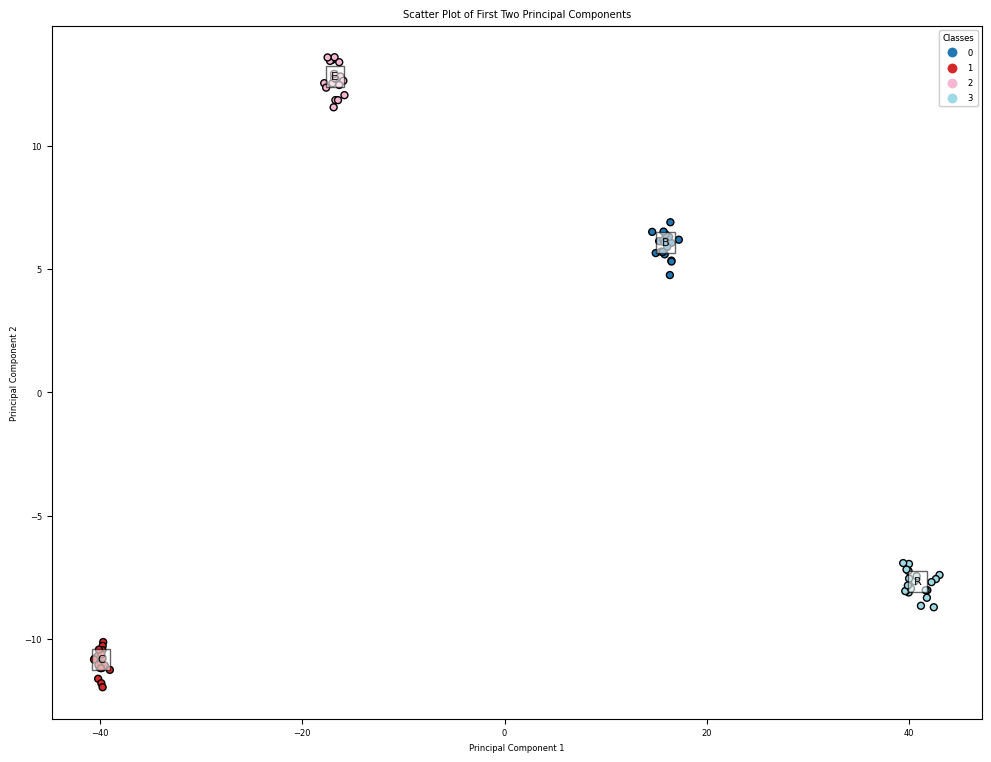

KeyError: '310.0 HG (mV) mean'

<Figure size 1200x900 with 0 Axes>

In [125]:
# Encode the labels
le = LabelEncoder()
y_new_sample_encoded = le.fit_transform(y_new_sample)

# Perform PCA
pca = PCA(n_components=2)
X_new_sample_pca = pca.fit_transform(X_new_sample)

# Create a DataFrame with the PCA components
components = pd.DataFrame(pca.components_, columns=X_new_sample.columns)
components = components.T

# Display the highest and lowest n variables of the first 3 components
n = 10
for i in range(pca.n_components_):
    print(f"Component {i+1}:")
    print(components[i].nlargest(n), '\n')
    print(components[i].nsmallest(n), '\n')

# Plot the PCA components (first two components for visualization)
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_new_sample_pca[:, 0], X_new_sample_pca[:, 1], c=y_new_sample_encoded, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0.1
unique_labels = np.unique(y_new_sample_encoded)
for i, label in enumerate(unique_labels):
    plt.text(X_new_sample_pca[y_new_sample_encoded == label][:, 0].mean(), 
             X_new_sample_pca[y_new_sample_encoded == label][:, 1].mean() + offset, 
             le.inverse_transform([label])[0], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of First Two Principal Components')

plt.show()


# Plot 2 input variables
var1 = '310.0 HG (mV)'
var2 = '360.0 HG (mV)'

var1 = '310.0 HG (mV) mean'
var2 = '360.0 HG (mV) mean'

plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_new_sample[var1], X_new_sample[var2], c=y_new_sample_encoded, cmap='tab20',
                      edgecolor='k', s=25)
# Produce a legend with the unique colors from the scatter
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)

# Show a class label on the data points (just one label per class in total)
offset = 0.1
unique_labels = np.unique(y_new_sample_encoded)

for i, label in enumerate(unique_labels):
    plt.text(X_new_sample[y_new_sample_encoded == label][var1].mean(), 
             X_new_sample[y_new_sample_encoded == label][var2].mean() + offset, 
             le.inverse_transform([label])[0], ha='center', va='center', size=8, bbox=dict(facecolor='w', alpha=0.6))
    
plt.xlabel(var1)
plt.ylabel(var2)
plt.title('Scatter Plot of Chosen Input Variables')

plt.show()




In [83]:
y_pred = rf_model.predict(X_new_sample, y_new_sample_encoded)
y_pred = nb_model.predict(X_new_sample, y_new_sample_encoded)
# y_pred = lr_model.predict(X_new_sample, y_new_sample_encoded)

# Calculate metrics
accuracy = accuracy_score(y_new_sample, y_pred)
precision = precision_score(y_new_sample, y_pred, average='weighted')
recall = recall_score(y_new_sample, y_pred, average='weighted')
f1 = f1_score(y_new_sample, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

# Convert the label encoded values back to the original class names
# y_new_sample = le.inverse_transform(y_new_sample)
# y_pred = le.inverse_transform(y_pred)

# Classification report
print(classification_report(le.inverse_transform(y_new_sample), le.inverse_transform(y_pred)), )

# Predictions made per class with its label encoded value
print(Counter(y_pred))

y_new_sample_encoded = le.inverse_transform(y_new_sample)
y_pred_encoded = le.inverse_transform(y_pred)

plot_confusion_matrix(y_new_sample_encoded, y_pred_encoded, le.classes_)

TypeError: ForestClassifier.predict() takes 2 positional arguments but 3 were given

In [183]:
# Load trained model
rf_model = joblib.load('random_forest_model.pkl')

# Predictions
y_pred = rf_model.predict(X_new_sample)



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 100.0 HG (mV) mean
- 100.0 HG (mV) std deviation
- 100.0 LG (mV) mean
- 100.0 LG (mV) std deviation
- 110.0 HG (mV) mean
- ...


## Feature Importance TBD

## Labels

| Original Label | Encoded Value |
|----------------|---------------|
| A1             | 0             |
| B1             | 1             |
| C1             | 2             |
| D1             | 3             |
| E1             | 4             |
| F1             | 5             |
| G1             | 6             |
| H1             | 7             |
| I1             | 8             |
| J1             | 9             |
| K1             | 10            |
| L1             | 11            |
| M1             | 12            |
| N1             | 13            |
| REF            | 14            |